# Exploratory Data Analysis for Assesing Pathogenicity Problem V.2.0

Note for Future: Utilize a GPU

This notebook was created  to showcase EDA for assesing pathogenicity problem. This is just the starting point for farther data analysis, due to allel library dropping some columns and losing us some data. Instead, future versions of EDA should include manually prepared data using pyvcf library.

### Imports and Data Reading

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import dalex as dx
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import GaussianNB

In [71]:
file_path1 = 'D:\pathogenicity_project\pathogenicity-data\EE_015.csv'
file_path2 = 'D:\pathogenicity_project\pathogenicity-data\EE_050.csv'
file_path3 = 'D:\pathogenicity_project\pathogenicity-data\EE_069.csv'
EE_015 = pd.read_csv(file_path1)
EE_050 = pd.read_csv(file_path2)
EE_069 = pd.read_csv(file_path3)

## Data Analysis

For the sake of simplicity in this step we will disregard the "CSQ" column and instead focus on remaining ones.

In [72]:
EE_015.drop(columns="CSQ", inplace=True)
EE_050.drop(columns="CSQ", inplace=True)
EE_069.drop(columns="CSQ", inplace=True)

From now on df is going to be our collective dataframe created by combining data from all other dataframes

In [73]:
df = pd.concat([EE_015, EE_050, EE_069], ignore_index=True)
df

CHROM       POS           ID REF ALT_1  ALT_2  ALT_3     QUAL  \
0       chr1     15820    rs2691315   G     T    NaN    NaN      NaN   
1       chr1     17385  rs201535981   G     A    NaN    NaN      NaN   
2       chr1     17697   rs71260069   G     C    NaN    NaN      NaN   
3       chr1    133129  rs367730352   G     A    NaN    NaN      NaN   
4       chr1    183629   rs71267774   G     A    NaN    NaN      NaN   
...      ...       ...          ...  ..   ...    ...    ...      ...   
444439  chrY  56856571    rs9988391   G     A    NaN    NaN   293.77   
444440  chrY  56856581    rs9320083   G     A    NaN    NaN   750.77   
444441  chrY  56856587    rs7067511   A     C    NaN    NaN  1164.77   
444442  chrY  56856668    rs5013140   A     G    NaN    NaN   467.77   
444443  chrY  56856670    rs5013141   G     T    NaN    NaN   467.77   

        FILTER_PASS  FILTER_SB  ...  MLEAC_2 MLEAC_3 MLEAF_1 MLEAF_2 MLEAF_3  \
0              True      False  ...      NaN     NaN     NaN     NaN     NaN   
1              True      False  ...      NaN     NaN     NaN     NaN     NaN   
2              True      False  ...      NaN     NaN     NaN     NaN     NaN   
3              True      False  ...      NaN     NaN     NaN     NaN     NaN   
4              True      False  ...      NaN     NaN     NaN     NaN     NaN   
...             ...        ...  ...      ...     ...     ...     ...     ...   
444439         True      False  ...     -1.0    -1.0     0.5     NaN     NaN   
444440         True      False  ...     -1.0    -1.0     0.5     NaN     NaN   
444441         True      False  ...     -1.0    -1.0     0.5     NaN     NaN   
444442         True      False  ...     -1.0    -1.0     0.5     NaN     NaN   
444443         True      False  ...     -1.0    -1.0     0.5     NaN     NaN   

           MQ MQRankSum     QD ReadPosRankSum    SOR  
0         NaN       NaN    NaN            NaN    NaN  
1         NaN       NaN    NaN            NaN    NaN  
2         NaN       NaN    NaN            NaN    NaN  
3         NaN       NaN    NaN            NaN    NaN  
4         NaN       NaN    NaN            NaN    NaN  
...       ...       ...    ...            ...    ...  
444439  41.25    -0.431   5.76         -1.020  0.419  
444440  41.23    -2.005  16.68         -0.205  0.361  
444441  40.19    -3.699  31.48         -1.691  0.530  
444442  44.02    -1.952  33.41          0.183  2.985  
444443  44.02    -1.952  33.41          0.549  2.985  

[444444 rows x 139 columns]

Droping all columns that have the words AMP and ACMG in their names

In [74]:
columns_to_drop = [col for col in df.columns if 'ACMG' in col and col != 'ACMG_class' or 'AMP' in col]
df = df.drop(columns=columns_to_drop)

The target attribute is ACMG_class. The cardinality of this attribute is 5 with the number of occurences of each example being written below. As can be seen some mutations are much rarer than others, so techniques to fight against problems related to minority class will need to be employed.

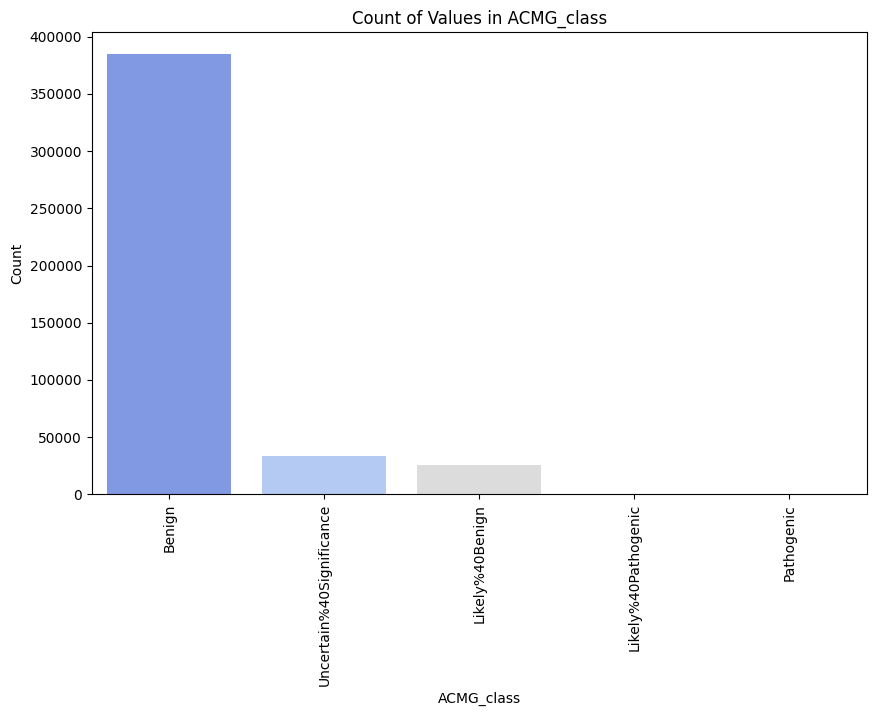

In [75]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='ACMG_class', order=df['ACMG_class'].value_counts().index, palette='coolwarm')
plt.xlabel('ACMG_class')
plt.ylabel('Count')
plt.title('Count of Values in ACMG_class')
plt.xticks(rotation=90)
plt.show()

Below Visualization is meant to provide information about the number of NaNs in chosen columns. Basically, we choose every column that has more than 100 000 Nans, meaning around 1/4th. If such a high numbers of Nans is present, me may consider dropping the column or doing something else with it. As such, We ended up visualizing all attributes for each number of Nans is greater than 100 000 to decide what to do with these columns farther. Some columns are all Nans or close to all Nans, as such dropping this data may be necessary.

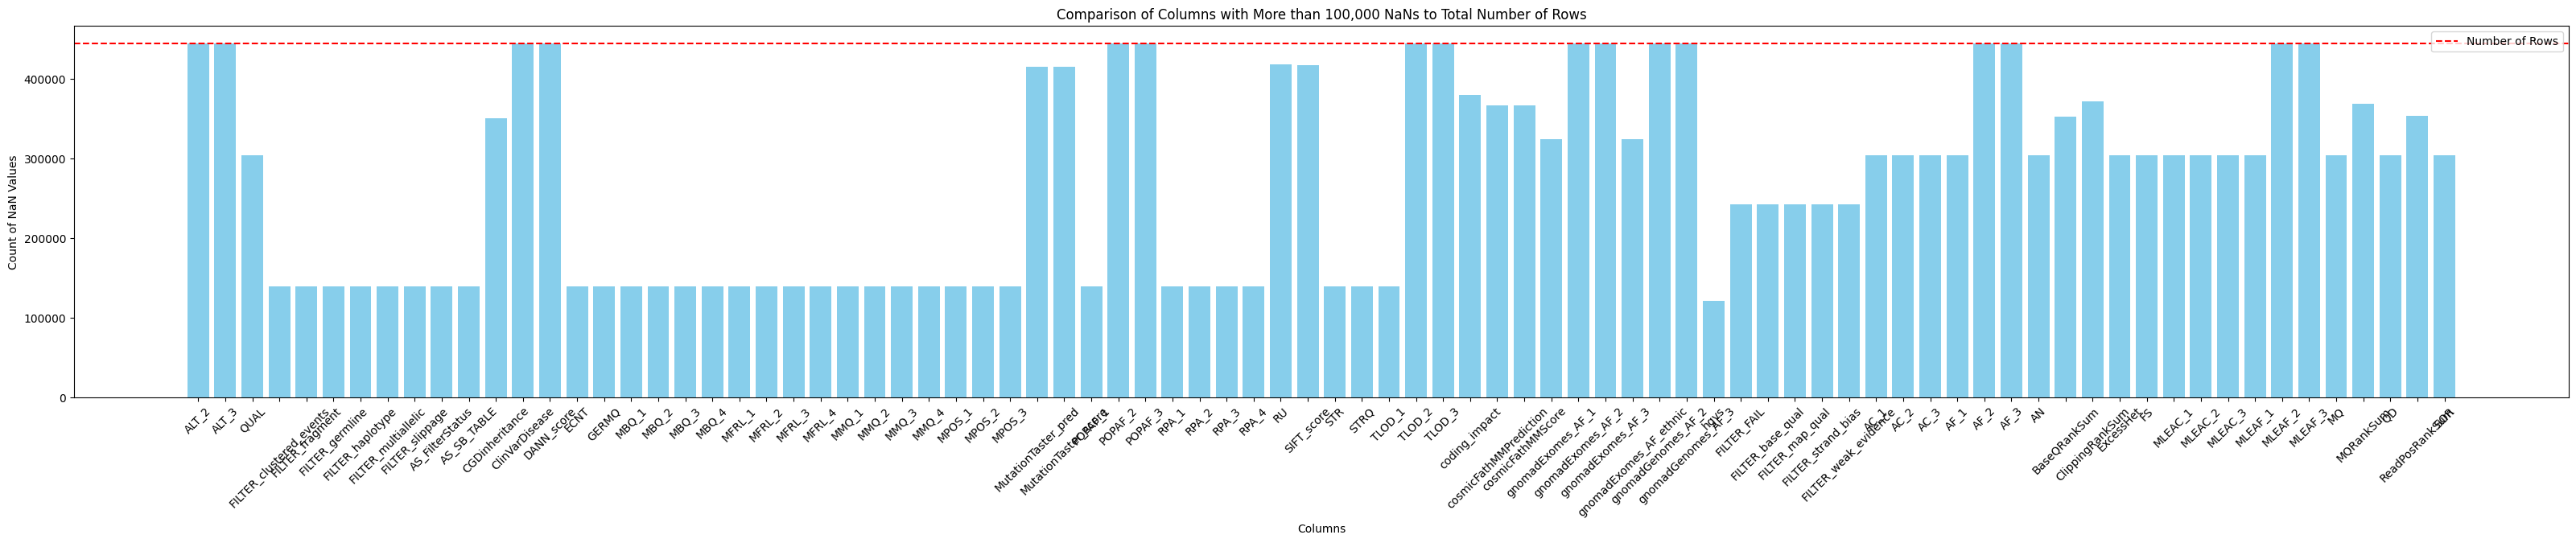

In [76]:
columns_with_nans = []
nan_counts = []
nan_threshold = 100000

for column in df.columns:
    nan_count = df[column].isna().sum()
    if nan_count > nan_threshold:
        columns_with_nans.append(column)
        nan_counts.append(nan_count)

total_rows = len(df)

plt.figure(figsize=(40, 6))
plt.bar(columns_with_nans, nan_counts, color='skyblue')
plt.axhline(y=total_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count of NaN Values')
plt.title('Comparison of Columns with More than 100,000 NaNs to Total Number of Rows')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Dropping all columns with more than 400000 Nans

In [77]:
nan_threshold = 400000

df = df.dropna(axis=1, thresh=len(df) - nan_threshold)

Looking through unique values for "object"(usually string) columns

In [78]:
for column in df.select_dtypes(include=['object']):
    unique_values_count = df[column].nunique()
    print(f"Column '{column}' has {unique_values_count} unique values.")

Column 'CHROM' has 76 unique values.
Column 'ID' has 271138 unique values.
Column 'REF' has 3555 unique values.
Column 'ALT_1' has 2881 unique values.
Column 'FILTER_clustered_events' has 2 unique values.
Column 'FILTER_fragment' has 2 unique values.
Column 'FILTER_germline' has 2 unique values.
Column 'FILTER_haplotype' has 2 unique values.
Column 'FILTER_multiallelic' has 2 unique values.
Column 'FILTER_slippage' has 2 unique values.
Column 'ACMG_class' has 5 unique values.
Column 'AS_FilterStatus' has 63 unique values.
Column 'AS_SB_TABLE' has 86334 unique values.
Column 'CGDinheritance' has 45 unique values.
Column 'Gene' has 26644 unique values.
Column 'STR' has 2 unique values.
Column 'coding_impact' has 9 unique values.
Column 'cosmicFathMMPrediction' has 4 unique values.
Column 'function' has 8 unique values.
Column 'hgvs' has 200918 unique values.
Column 'FILTER_FAIL' has 2 unique values.
Column 'FILTER_base_qual' has 2 unique values.
Column 'FILTER_map_qual' has 2 unique valu

Visualizing numbers of unique values for every "object" attribute, that way we may know if we should treat them as categorical or not.

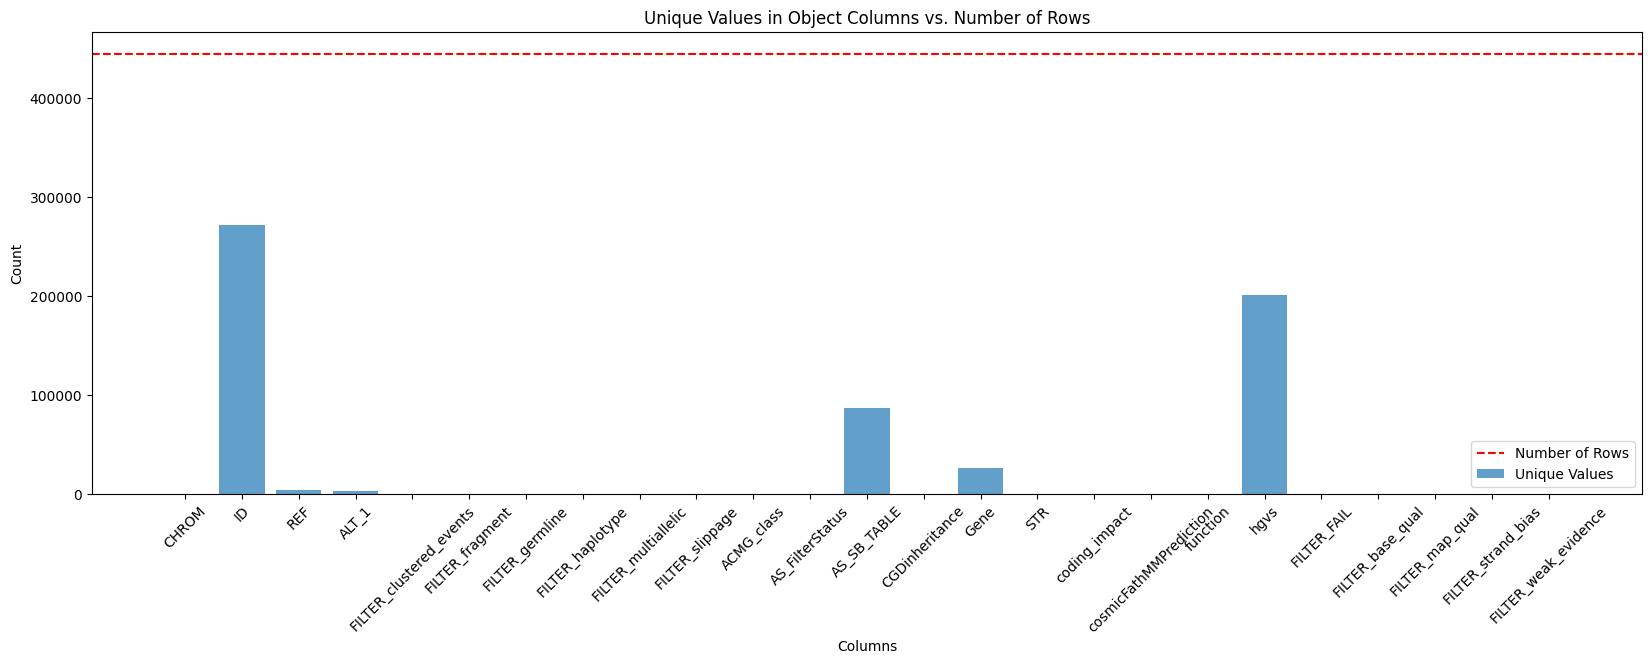

In [79]:
unique_value_counts = []
column_names = []
for column in df.select_dtypes(include=['object']):
    column_names.append(column)
    unique_values_count = df[column].nunique()
    unique_value_counts.append(unique_values_count)

num_rows = len(df)

plt.figure(figsize=(20, 6))
plt.bar(column_names, unique_value_counts, label='Unique Values', alpha=0.7)
plt.axhline(y=num_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Unique Values in Object Columns vs. Number of Rows')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [80]:
df["ACMG_class"]

0         Uncertain%40Significance
1         Uncertain%40Significance
2                           Benign
3         Uncertain%40Significance
4                           Benign
                    ...           
444439    Uncertain%40Significance
444440    Uncertain%40Significance
444441    Uncertain%40Significance
444442    Uncertain%40Significance
444443    Uncertain%40Significance
Name: ACMG_class, Length: 444444, dtype: object

Changing every attribute that has less than 10000 unique values to a category.

In [81]:
unique_value_threshold = 10000

for column in df.select_dtypes(include=['object']):
    unique_values_count = df[column].nunique()
    if unique_values_count < unique_value_threshold:
        df[column] = df[column].astype('category')


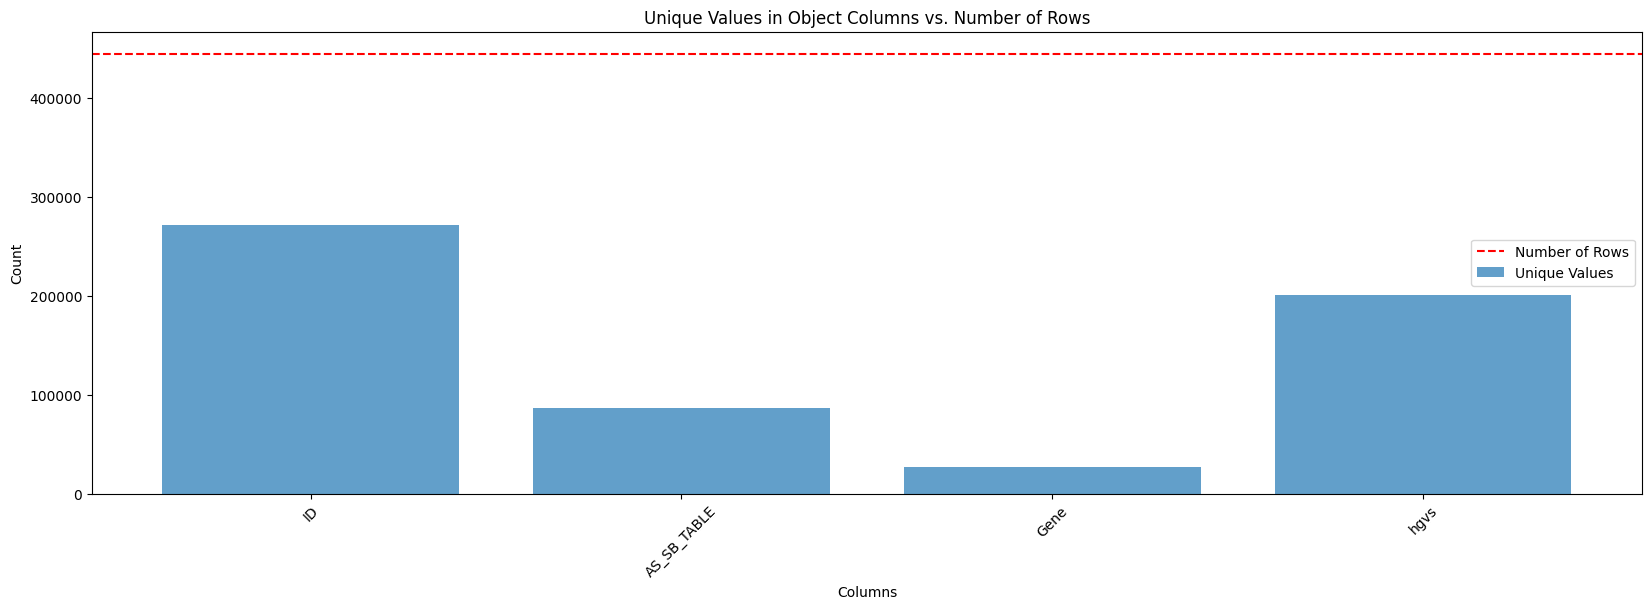

In [82]:
unique_value_counts = []
column_names = []
for column in df.select_dtypes(include=['object']):
    column_names.append(column)
    unique_values_count = df[column].nunique()
    unique_value_counts.append(unique_values_count)

num_rows = len(df)

plt.figure(figsize=(20, 6))
plt.bar(column_names, unique_value_counts, label='Unique Values', alpha=0.7)
plt.axhline(y=num_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Unique Values in Object Columns vs. Number of Rows')
plt.legend()
plt.xticks(rotation=45)
plt.show()


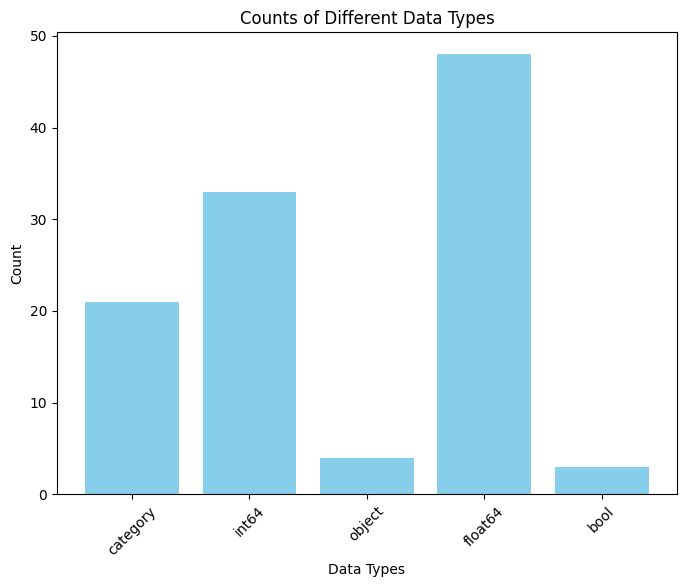

In [83]:
dtype_counts={}
for val in df.dtypes:
    try:
        dtype_counts[str(val)]+=1
    except:
        dtype_counts[str(val)]=1

data_types = list(dtype_counts.keys())
counts = list(dtype_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(data_types, counts, color='skyblue')
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.title('Counts of Different Data Types')
plt.xticks(rotation=45)
plt.show()

Heatmap showing correlation of 15 attributes with highest average correlation.

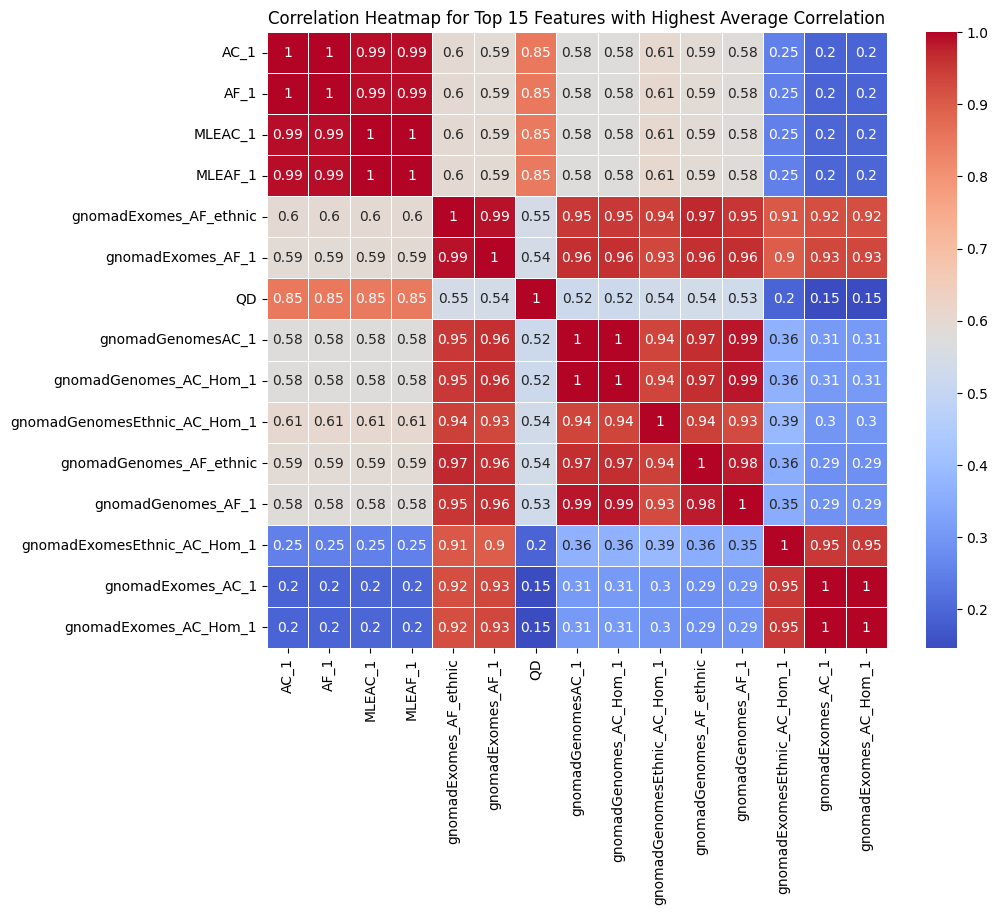

In [84]:
numeric_df = df.select_dtypes(include=['int64', 'float64', 'bool'])


correlation_matrix = numeric_df.corr()
average_correlation = correlation_matrix.abs().mean(axis=1)
top_features = average_correlation.nlargest(15).index

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for Top 15 Features with Highest Average Correlation')
plt.show()



In [85]:
unique_value_threshold = 50000

for column in df.columns:
    unique_values_count = df[column].nunique()
    if unique_values_count < unique_value_threshold:
        df[column] = df[column].astype('category')


Below, everything that was an object was changed to category, same for some numerical attributes that had less than 50 000 unique values. This should probably be reviewed and possibly changed in the final implementation.

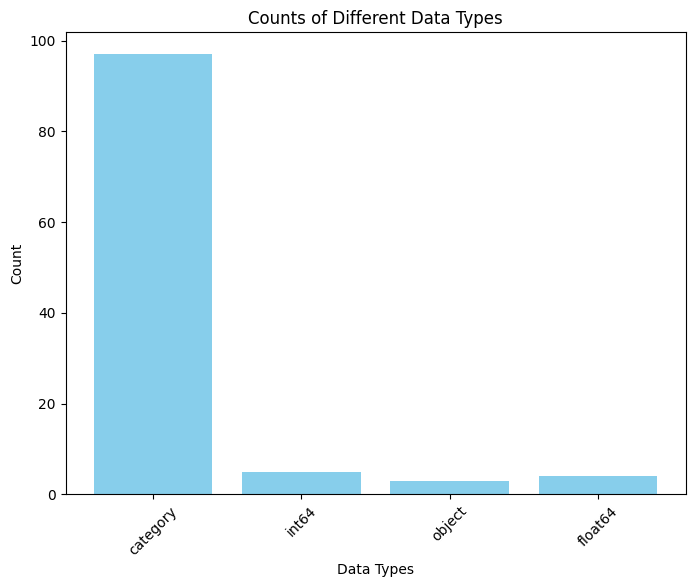

In [86]:
dtype_counts={}
for val in df.dtypes:
    try:
        dtype_counts[str(val)]+=1
    except:
        dtype_counts[str(val)]=1

data_types = list(dtype_counts.keys())
counts = list(dtype_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(data_types, counts, color='skyblue')
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.title('Counts of Different Data Types')
plt.xticks(rotation=45)
plt.show()

Heatmap of correlations for all remaining numerical values.

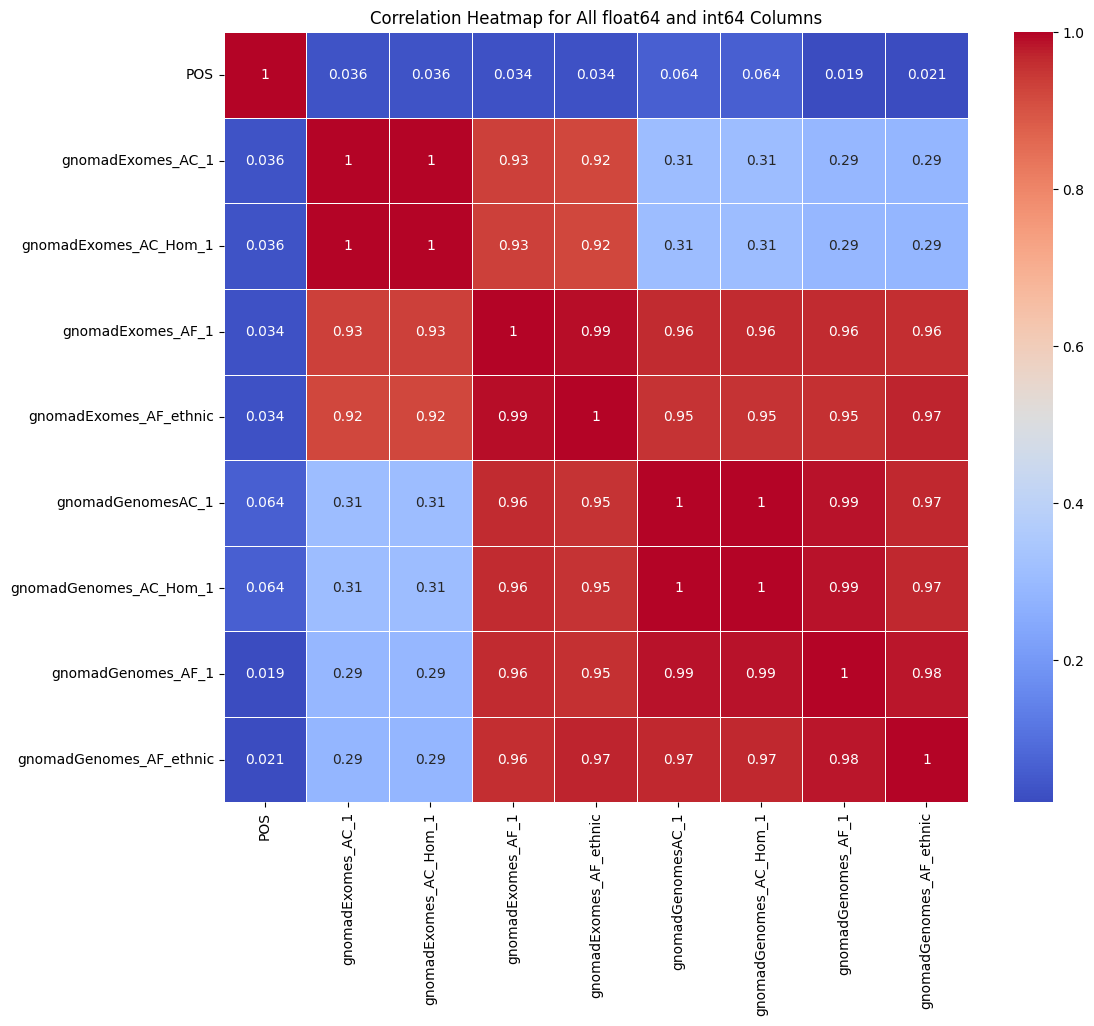

In [87]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])


correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for All float64 and int64 Columns')
plt.show()


In [88]:
acmg_class_names = list(df["ACMG_class"])

In [89]:
category_columns = df.select_dtypes(include=['category'])
for column in category_columns:
    category_to_numeric_mapping = {category: index for index, category in enumerate(df[column].cat.categories)}
    df[column] = df[column].cat.codes

object_columns = df.select_dtypes(include=['object'])
for column in object_columns:
    df[column] = df[column].astype('category').cat.codes



In [90]:
acmg_class_vals = list(df["ACMG_class"])

In [91]:
acmg_mapping={}
for i in range(len(acmg_class_names)):
    name = acmg_class_names[i]
    if name not in list(acmg_mapping.keys()):
        acmg_mapping[name] = acmg_class_vals[i]
    if len(list(acmg_mapping.keys())) == 5:
        break
acmg_mapping

{'Uncertain%40Significance': 4,
 'Benign': 0,
 'Likely%40Benign': 1,
 'Likely%40Pathogenic': 2,
 'Pathogenic': 3}

Showing correlation between 15 most correlated attributes with our target attribute.

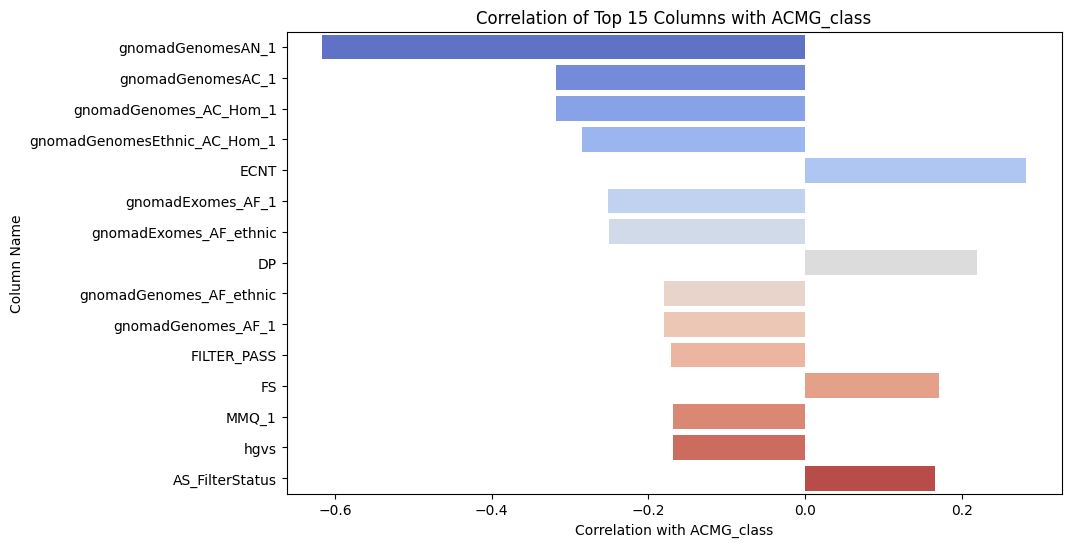

In [92]:
correlation_with_ACMG_class = df.corr()['ACMG_class'].drop('ACMG_class')

top_columns = correlation_with_ACMG_class.abs().nlargest(15).index

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_ACMG_class[top_columns], y=top_columns, orient='h', palette='coolwarm')
plt.xlabel('Correlation with ACMG_class')
plt.ylabel('Column Name')
plt.title('Correlation of Top 15 Columns with ACMG_class')
plt.show()

Showing mutual information between 15 chosen attributes with our target attribute. Nans had to be chnaged to mean for the model to work.

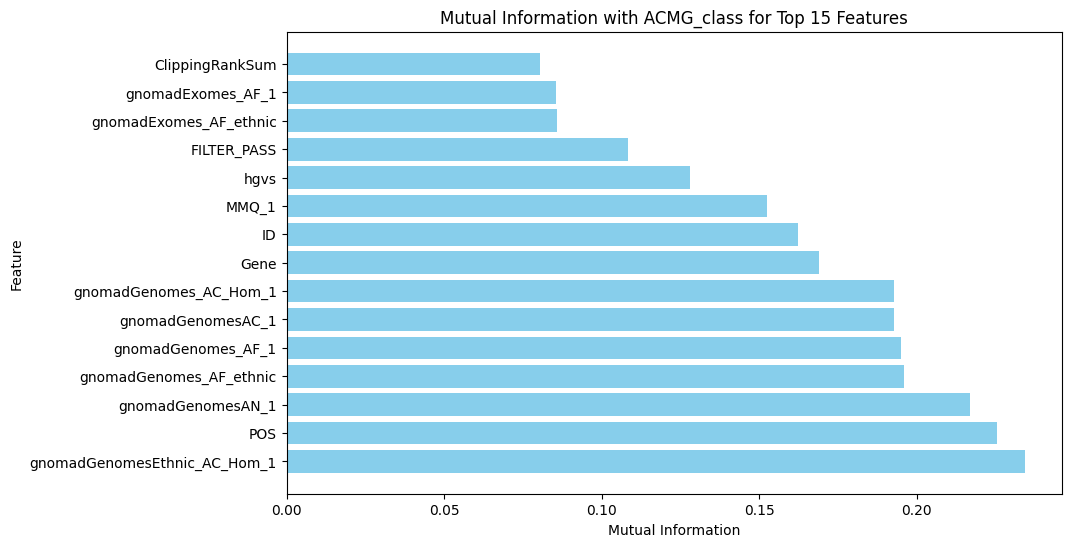

In [93]:
target_column = 'ACMG_class'
df_copy = df.copy()
non_numeric_columns = df_copy.select_dtypes(exclude=['number']).columns
label_encoders = {}

for column in non_numeric_columns:
    label_encoders[column] = LabelEncoder()
    df_copy[column] = label_encoders[column].fit_transform(df_copy[column])

imputer = SimpleImputer(strategy='mean')
X = df_copy.drop(columns=[target_column])
X_imputed = imputer.fit_transform(X)
y = df_copy[target_column]
mutual_info = mutual_info_classif(X_imputed, y)


mutual_info_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)
top_features = mutual_info_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Mutual Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.title('Mutual Information with ACMG_class for Top 15 Features')
plt.show()


## Model Training

Training and reviewing a simple model. Nans were changed to median to allow the model to learn.

In [94]:
imputer = SimpleImputer(strategy='median')
X = df.drop(columns=['ACMG_class'])
X = imputer.fit_transform(X)
y = df['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
clf = RandomForestClassifier(class_weight=dict(enumerate(class_weights)))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.79      0.79      0.79      5141
           2       1.00      0.06      0.11        18
           3       0.00      0.00      0.00         9
           4       0.88      0.78      0.82      6565

    accuracy                           0.96     88889
   macro avg       0.73      0.52      0.54     88889
weighted avg       0.96      0.96      0.96     88889



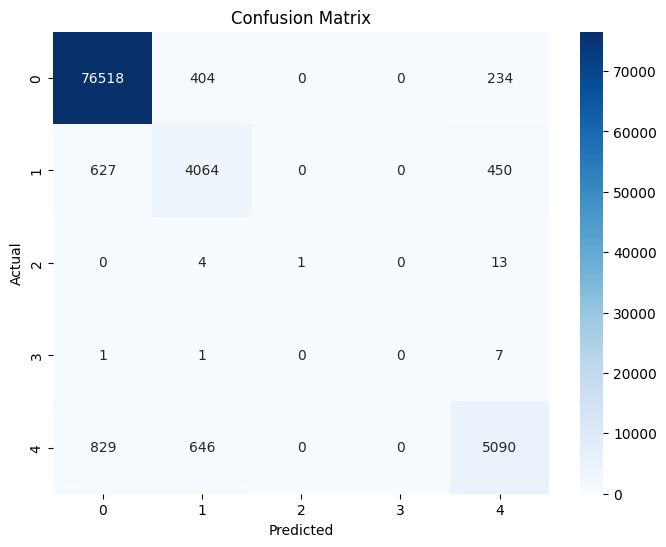

In [95]:
confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
class_names = clf.classes_
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [96]:
acmg_mapping

{'Uncertain%40Significance': 4,
 'Benign': 0,
 'Likely%40Benign': 1,
 'Likely%40Pathogenic': 2,
 'Pathogenic': 3}

### Pipeline for Trying multiple different models in sklearn

<b> Approximate Cell Runtime: 10 - 15 minutes </b>

This pipeline compares the performance of different models implemented in sklearn: Random Forrest, AdaBoost, Decision Tree, Logistic Regression, Bagging.

The results are shown in the form of a confusion matrix. The most promissing model appears to be AdaBoost.

Good performance on majority class is often balanced by bad performance minority class and vice-verse, as such ensamble models might be a good idea.

For Future Considerations: 
* More classifiers
* Different Preprocessign nested in the pipeline

Class Assignment:
* 'Benign': 0
* 'Likely%40Benign': 1
* 'Likely%40Pathogenic': 2
* 'Pathogenic': 3
* 'Uncertain%40Significance': 4

Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.79      0.79      0.79      5141
           2       1.00      0.11      0.20        18
           3       0.00      0.00      0.00         9
           4       0.88      0.78      0.82      6565

    accuracy                           0.96     88889
   macro avg       0.73      0.53      0.56     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for Random Forest:


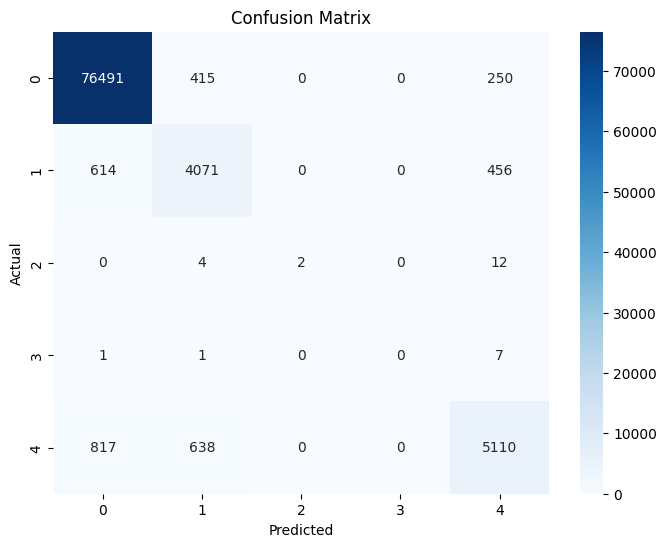

Classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     77156
           1       0.33      0.25      0.28      5141
           2       0.01      0.72      0.02        18
           3       0.24      0.56      0.33         9
           4       0.50      0.51      0.50      6565

    accuracy                           0.89     88889
   macro avg       0.41      0.60      0.42     88889
weighted avg       0.89      0.89      0.89     88889

Confusion matrix for AdaBoost:


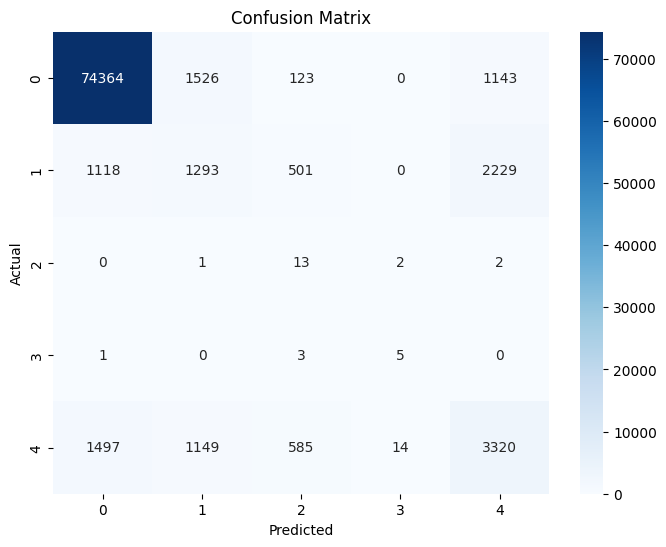

Classification report for Bagging:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.79      0.80      0.79      5141
           2       0.67      0.22      0.33        18
           3       0.00      0.00      0.00         9
           4       0.87      0.79      0.83      6565

    accuracy                           0.96     88889
   macro avg       0.66      0.56      0.59     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for Bagging:


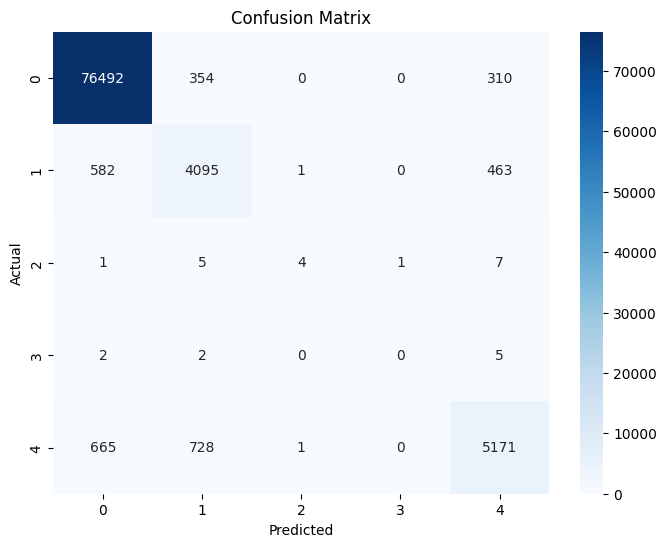

Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     77156
           1       0.71      0.70      0.71      5141
           2       0.23      0.33      0.27        18
           3       0.00      0.00      0.00         9
           4       0.76      0.78      0.77      6565

    accuracy                           0.95     88889
   macro avg       0.54      0.56      0.55     88889
weighted avg       0.95      0.95      0.95     88889

Confusion matrix for Decision Tree:


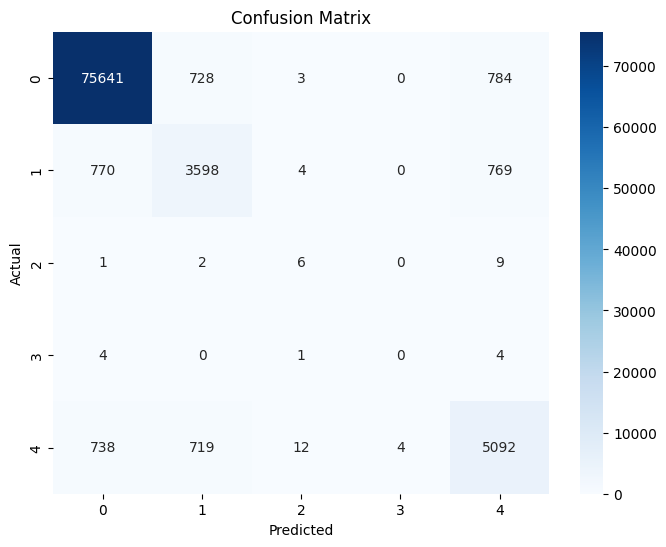

Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     77156
           1       0.12      0.25      0.17      5141
           2       0.00      0.39      0.00        18
           3       0.00      0.33      0.00         9
           4       0.39      0.38      0.38      6565

    accuracy                           0.71     88889
   macro avg       0.30      0.42      0.28     88889
weighted avg       0.87      0.71      0.78     88889

Confusion matrix for Logistic Regression:


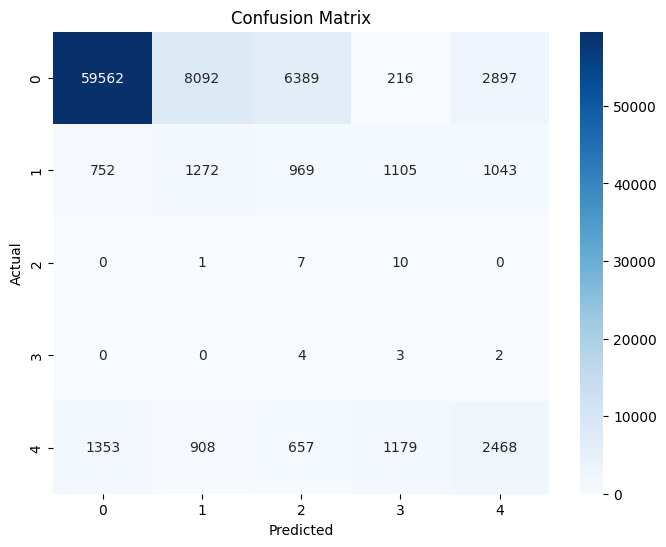

In [97]:
imputer = SimpleImputer(strategy='median')
X = df.drop(columns=['ACMG_class'])
X = imputer.fit_transform(X)
y = df['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
seeds = [42, 123, 456, 789, 555, 111, 888, 999]

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

models = [
    ('Random Forest', RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=seeds[0])),
    ('AdaBoost', AdaBoostClassifier(random_state=seeds[1])),
    ('Bagging', BaggingClassifier(random_state=seeds[2])),
    ('Decision Tree', DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=seeds[3])),
    ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight=dict(enumerate(class_weights)), random_state=seeds[4])),
    
]

for model_name, model in models:
    clf = model

    pipeline = Pipeline([
        ('classifier', clf)
    ])

    if model_name == 'Voting Classifier':
        clf.set_params(gb__sample_weight=class_weights[np.searchsorted(np.unique(y_train), y_train)])
    elif model_name == 'AdaBoost':
        sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
        pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    else:
        pipeline.fit(X_train, y_train)
    
    if model_name != 'AdaBoost':
        y_pred = pipeline.predict(X_test)
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        y_pred = pipeline.predict(X_test)
        
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        classes = np.unique(y)
        cm = confusion_matrix(y_test, y_pred, labels=classes)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()


<b> Approximate Cell Runtime: 5 - 8 hours </b> <br>

<b> Note: You do not need to run this cell to run later cells (for now at the very least) </b> <br>

<b> Note 2: If an error occurs in 'classifier__estimator': [DecisionTreeClassifier(max_depth=1) ...] the it may be related to your Sklearn's version, you can change the code to 'classifier__base_estimator': [DecisionTreeClassifier(max_depth=1), ...] </b> <br>

Random Search with 10 reruns for each model to find the best parameters.

For Future Considerations: 
* Weighted F1 does not proritize minority classes as much as expected. Find a better alternative to decide best hyperparameters or do this by hand.
* Run with more models and hyperparameters, logistic can be disregarded and removed from the pipeline

Class Assignment:
* 'Benign': 0
* 'Likely%40Benign': 1
* 'Likely%40Pathogenic': 2
* 'Pathogenic': 3
* 'Uncertain%40Significance': 4

Best parameters for Random Forest:
{'classifier__random_state': 42, 'classifier__n_estimators': 500, 'classifier__max_depth': None}
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.80      0.80      0.80      5141
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00         9
           4       0.88      0.79      0.83      6565

    accuracy                           0.97     88889
   macro avg       0.53      0.52      0.52     88889
weighted avg       0.96      0.97      0.96     88889

Confusion matrix for Random Forest:


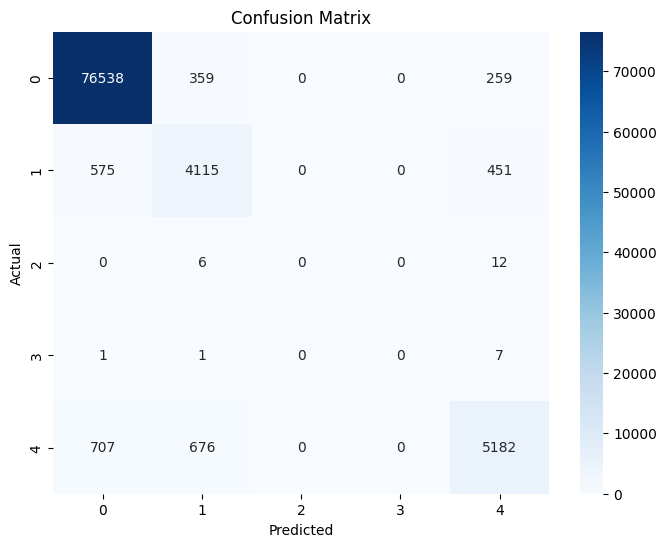

Best parameters for AdaBoost:
{'classifier__random_state': 42, 'classifier__n_estimators': 20, 'classifier__learning_rate': 0.1, 'classifier__estimator': RandomForestClassifier()}
Classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.80      0.79      0.79      5141
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00         9
           4       0.89      0.77      0.83      6565

    accuracy                           0.96     88889
   macro avg       0.53      0.51      0.52     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for AdaBoost:


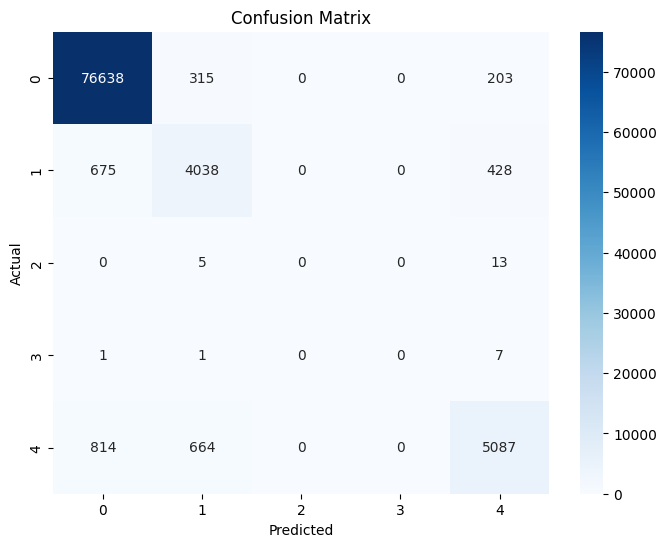

Best parameters for Logistic Regression:
{'classifier__random_state': 42, 'classifier__penalty': 'l2', 'classifier__C': 10.0}
Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     77156
           1       0.53      0.18      0.27      5141
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00         9
           4       0.60      0.30      0.40      6565

    accuracy                           0.90     88889
   macro avg       0.41      0.29      0.32     88889
weighted avg       0.87      0.90      0.87     88889

Confusion matrix for Logistic Regression:


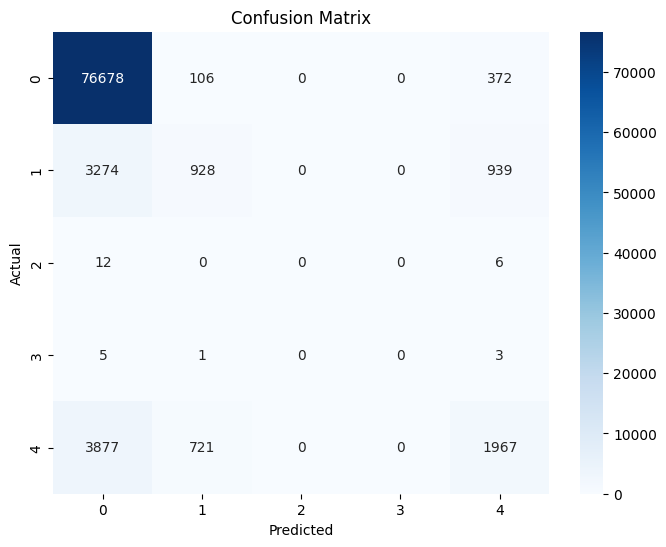

Best parameters for Decision Tree:
{'classifier__random_state': 42, 'classifier__min_samples_split': 10, 'classifier__max_depth': 10, 'classifier__criterion': 'gini'}
Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     77156
           1       0.76      0.77      0.77      5141
           2       1.00      0.06      0.11        18
           3       0.00      0.00      0.00         9
           4       0.81      0.78      0.80      6565

    accuracy                           0.96     88889
   macro avg       0.71      0.52      0.53     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for Decision Tree:


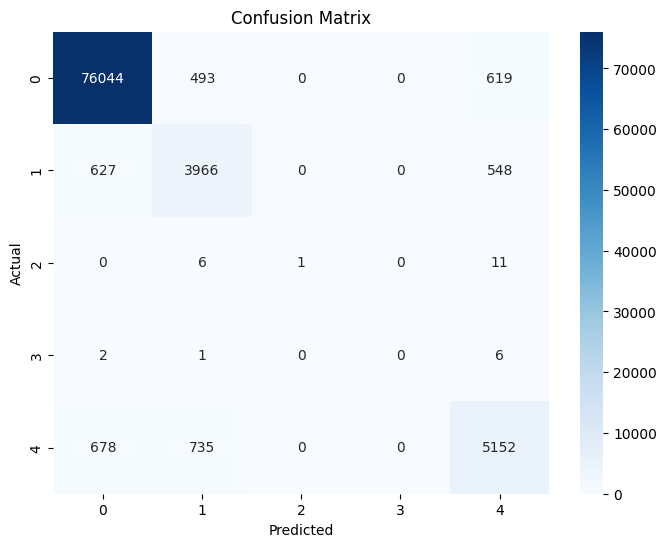

In [98]:
imputer = SimpleImputer(strategy='median')
X = df.drop(columns=['ACMG_class'])
X = imputer.fit_transform(X)
y = df['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

models = [
    
    ('Random Forest', RandomForestClassifier(), {
        'classifier__n_estimators': [50, 100, 150, 500, 700],
        'classifier__max_depth': [None, 5, 10, 15],
         'classifier__random_state': [42]
    }),
    ('AdaBoost', AdaBoostClassifier(), {
        'classifier__estimator': [DecisionTreeClassifier(max_depth=1), RandomForestClassifier(n_estimators=100), KNeighborsClassifier(n_neighbors=3)],
        'classifier__n_estimators': [20, 50, 100, 150],
        'classifier__learning_rate': [0.01, 0.1, 1.0],
        'classifier__random_state': [42]
    }),
    ('Logistic Regression', LogisticRegression(max_iter=1000), {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__random_state': [42],
    }),
    ('Decision Tree', DecisionTreeClassifier(), {
        'classifier__max_depth': [None, 5, 10, 15, 30, 100],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__random_state': [42]
    })
]

for model_name, model, params in models:
    clf = model
    pipeline = Pipeline([
        ('classifier', clf)
    ])

    rand_search = RandomizedSearchCV(pipeline, params, cv=skf, scoring='f1_weighted', n_iter=10, random_state=42)
    rand_search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}:")
    print(rand_search.best_params_)

    best_model = rand_search.best_estimator_
    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred)
    print(f"Classification report for {model_name}:")
    print(report)

    cm = confusion_matrix(y_test, y_pred, labels=classes)
    print(f"Confusion matrix for {model_name}:")
    plt.figure(figsize=(8, 6))
    try:
        class_names = clf.classes_
    except:
        class_names = [0,1,2,3,4]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

<b> Approximate Cell Runtime: 2 - 6 hours</b> <br>

Creating pipeline of ensamble models to attempt to get better performance for both minority and majority class

Class Assignment:
* 'Benign': 0
* 'Likely%40Benign': 1
* 'Likely%40Pathogenic': 2
* 'Pathogenic': 3
* 'Uncertain%40Significance': 4

Classification report for voting_clf_1:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     77156
           1       0.71      0.70      0.70      5141
           2       0.23      0.33      0.27        18
           3       0.20      0.11      0.14         9
           4       0.77      0.78      0.77      6565

    accuracy                           0.95     88889
   macro avg       0.58      0.58      0.58     88889
weighted avg       0.95      0.95      0.95     88889

Confusion matrix for voting_clf_1:


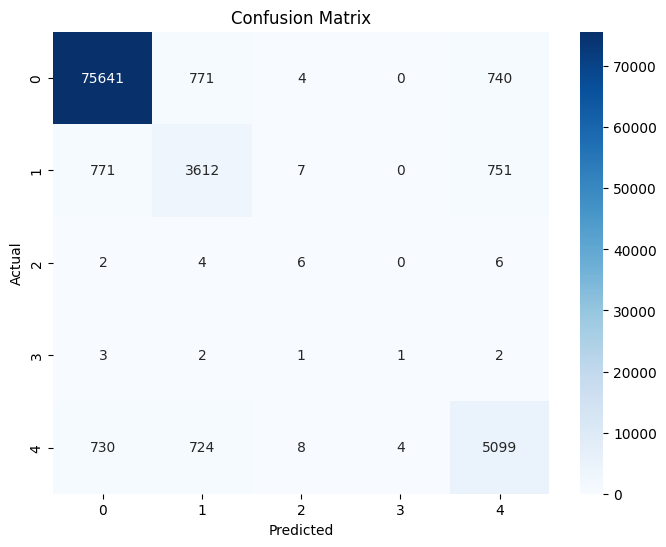

Classification report for voting_clf_2:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.78      0.76      0.77      5141
           2       0.27      0.22      0.24        18
           3       1.00      0.11      0.20         9
           4       0.84      0.80      0.82      6565

    accuracy                           0.96     88889
   macro avg       0.77      0.58      0.60     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for voting_clf_2:


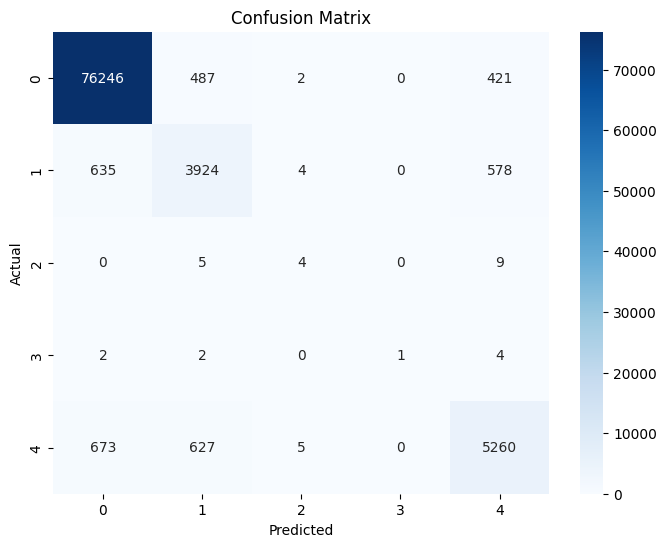

Classification report for voting_clf_3:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     77156
           1       0.72      0.71      0.72      5141
           2       0.23      0.33      0.27        18
           3       0.20      0.11      0.14         9
           4       0.79      0.78      0.79      6565

    accuracy                           0.95     88889
   macro avg       0.59      0.58      0.58     88889
weighted avg       0.95      0.95      0.95     88889

Confusion matrix for voting_clf_3:


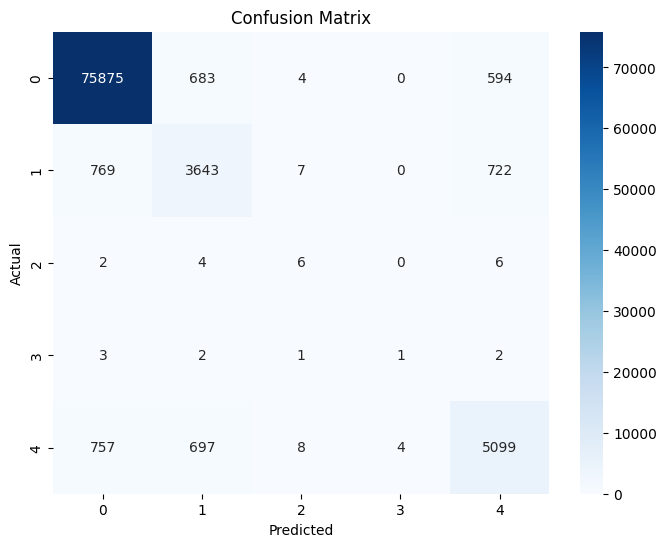

Classification report for voting_clf_4:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     77156
           1       0.73      0.72      0.72      5141
           2       0.29      0.33      0.31        18
           3       0.20      0.11      0.14         9
           4       0.79      0.78      0.78      6565

    accuracy                           0.95     88889
   macro avg       0.60      0.59      0.59     88889
weighted avg       0.95      0.95      0.95     88889

Confusion matrix for voting_clf_4:


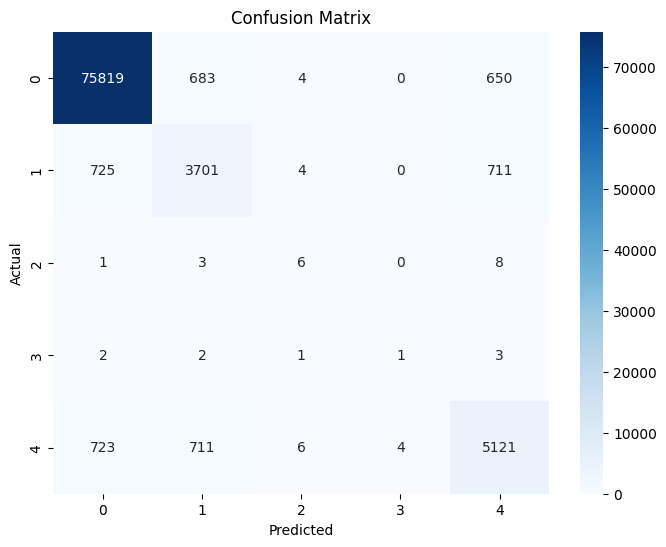

Classification report for voting_clf_5:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.78      0.76      0.77      5141
           2       0.27      0.22      0.24        18
           3       1.00      0.11      0.20         9
           4       0.84      0.80      0.82      6565

    accuracy                           0.96     88889
   macro avg       0.77      0.58      0.60     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for voting_clf_5:


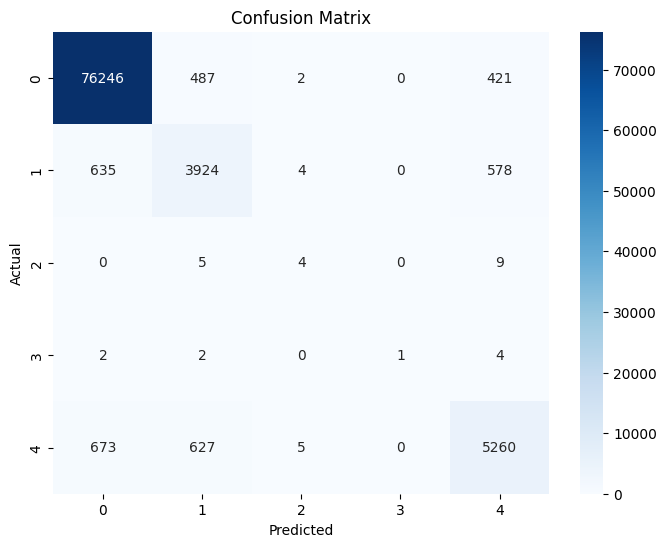

Classification report for voting_clf_6:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     77156
           1       0.71      0.70      0.71      5141
           2       0.24      0.33      0.28        18
           3       0.20      0.11      0.14         9
           4       0.77      0.77      0.77      6565

    accuracy                           0.95     88889
   macro avg       0.58      0.58      0.58     88889
weighted avg       0.95      0.95      0.95     88889

Confusion matrix for voting_clf_6:


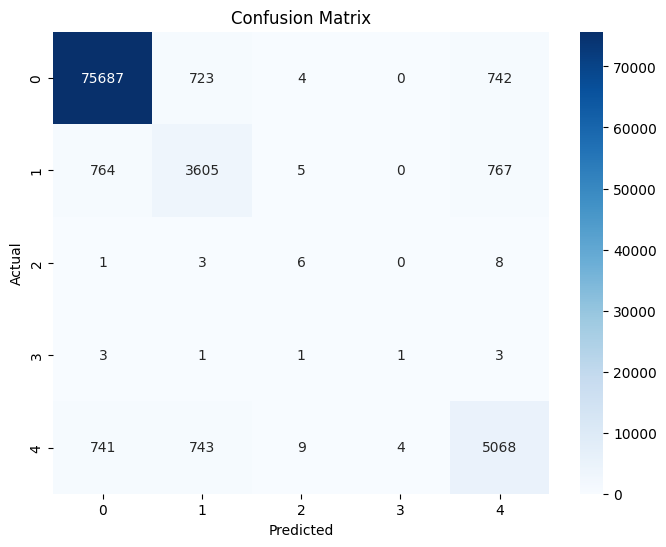

Classification report for voting_clf_7:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.80      0.80      0.80      5141
           2       1.00      0.06      0.11        18
           3       0.00      0.00      0.00         9
           4       0.87      0.80      0.83      6565

    accuracy                           0.97     88889
   macro avg       0.73      0.53      0.55     88889
weighted avg       0.97      0.97      0.97     88889

Confusion matrix for voting_clf_7:


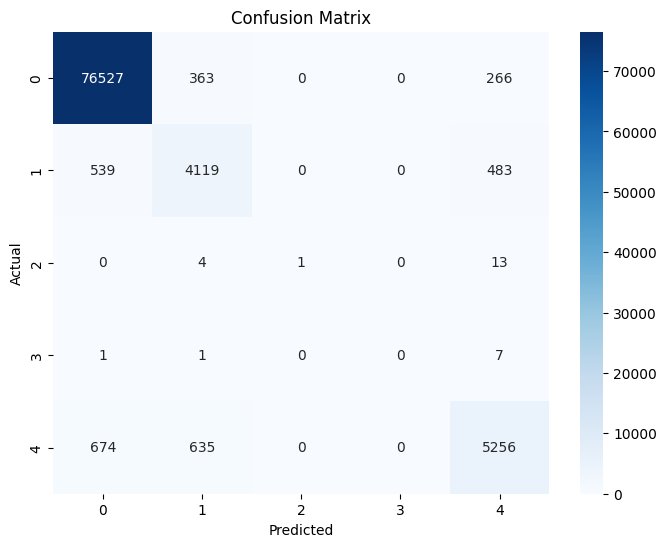

Classification report for voting_clf_8:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     77156
           1       0.75      0.70      0.72      5141
           2       0.40      0.33      0.36        18
           3       0.00      0.00      0.00         9
           4       0.82      0.76      0.79      6565

    accuracy                           0.95     88889
   macro avg       0.59      0.56      0.57     88889
weighted avg       0.95      0.95      0.95     88889

Confusion matrix for voting_clf_8:


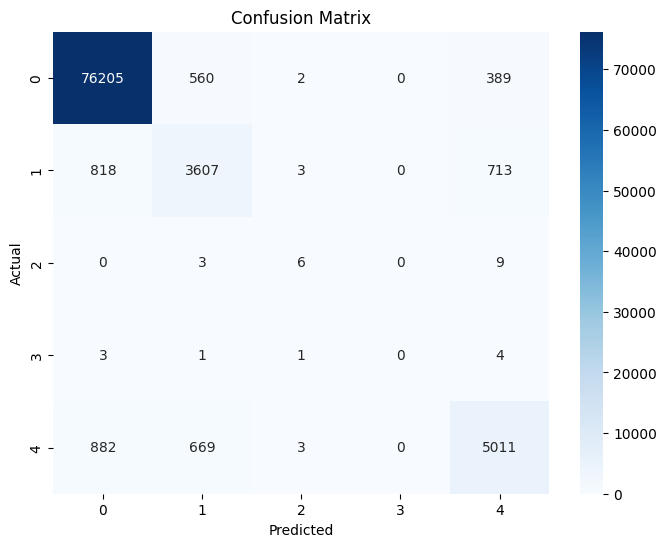

Classification report for voting_clf_9:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.80      0.77      0.78      5141
           2       1.00      0.06      0.11        18
           3       0.00      0.00      0.00         9
           4       0.87      0.76      0.81      6565

    accuracy                           0.96     88889
   macro avg       0.73      0.51      0.54     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for voting_clf_9:


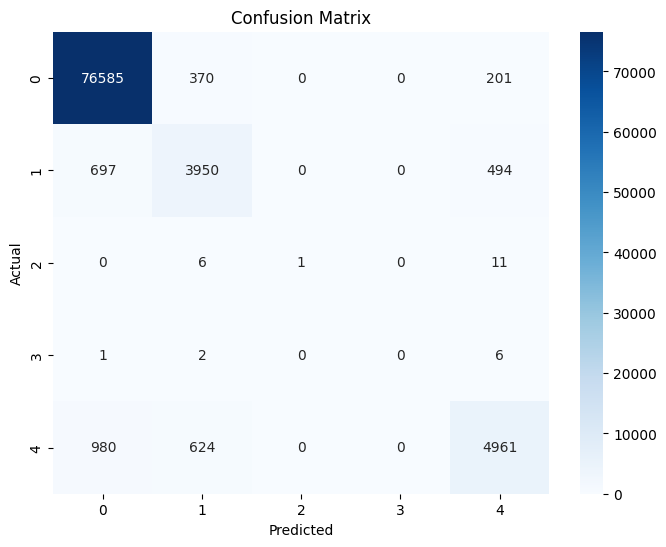

Classification report for voting_clf_10:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     77156
           1       0.75      0.73      0.74      5141
           2       0.30      0.33      0.32        18
           3       0.33      0.11      0.17         9
           4       0.82      0.78      0.80      6565

    accuracy                           0.96     88889
   macro avg       0.64      0.59      0.60     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for voting_clf_10:


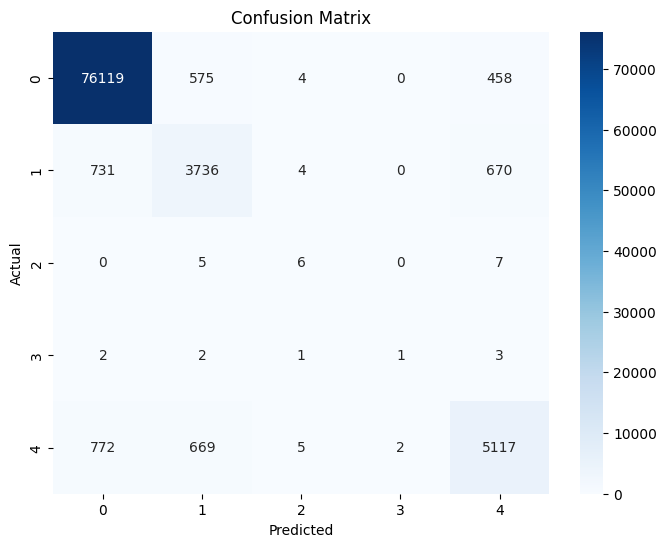

Classification report for voting_clf_11:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.78      0.77      0.77      5141
           2       0.31      0.22      0.26        18
           3       1.00      0.11      0.20         9
           4       0.84      0.80      0.82      6565

    accuracy                           0.96     88889
   macro avg       0.78      0.58      0.61     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for voting_clf_11:


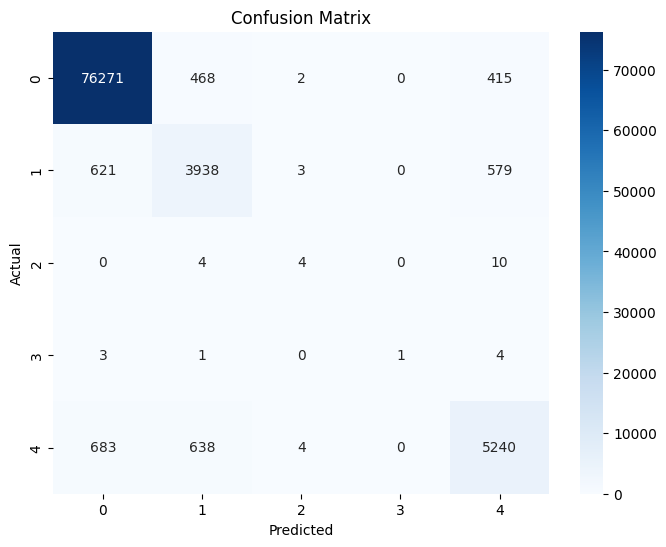

Classification report for voting_clf_12:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     77156
           1       0.77      0.74      0.75      5141
           2       0.43      0.33      0.38        18
           3       0.20      0.11      0.14         9
           4       0.92      0.70      0.79      6565

    accuracy                           0.96     88889
   macro avg       0.66      0.57      0.61     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for voting_clf_12:


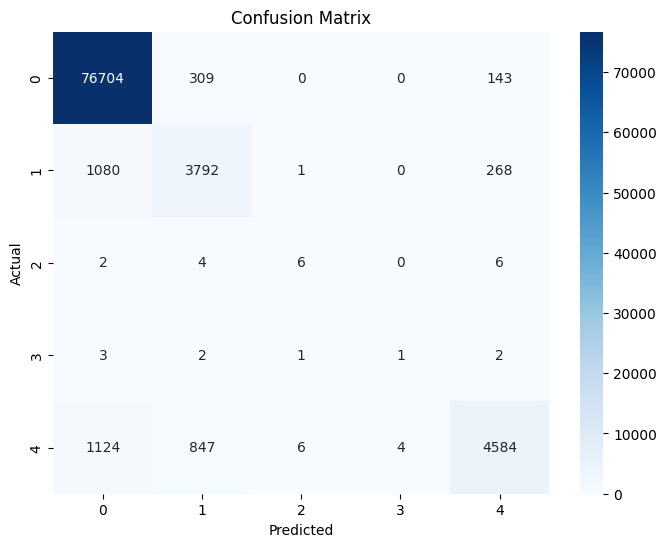

Classification report for voting_clf_13:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     77156
           1       0.77      0.72      0.74      5141
           2       1.00      0.11      0.20        18
           3       0.00      0.00      0.00         9
           4       0.87      0.74      0.80      6565

    accuracy                           0.96     88889
   macro avg       0.72      0.51      0.54     88889
weighted avg       0.95      0.96      0.95     88889

Confusion matrix for voting_clf_13:


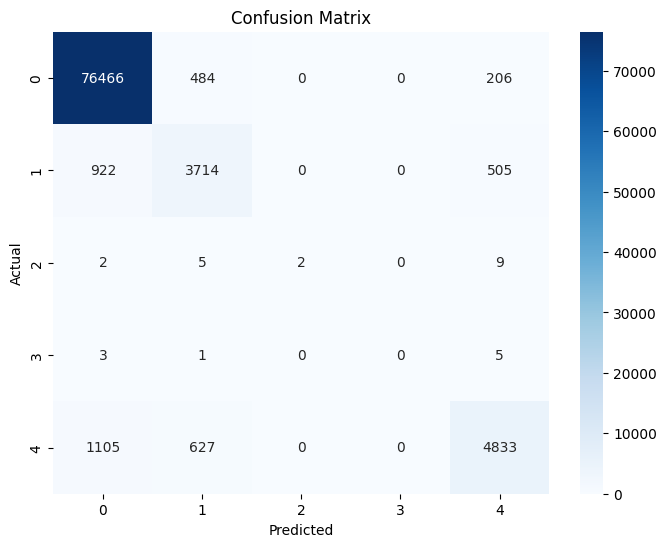

Classification report for voting_clf_14:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.80      0.77      0.78      5141
           2       1.00      0.06      0.11        18
           3       0.00      0.00      0.00         9
           4       0.89      0.76      0.82      6565

    accuracy                           0.96     88889
   macro avg       0.73      0.52      0.54     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for voting_clf_14:


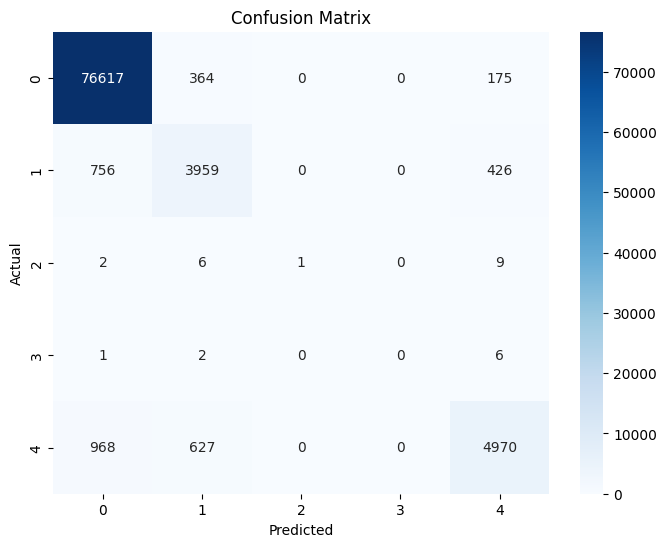

Classification report for voting_clf_15:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     77156
           1       0.76      0.76      0.76      5141
           2       0.32      0.33      0.32        18
           3       0.20      0.11      0.14         9
           4       0.87      0.75      0.80      6565

    accuracy                           0.96     88889
   macro avg       0.62      0.59      0.60     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for voting_clf_15:


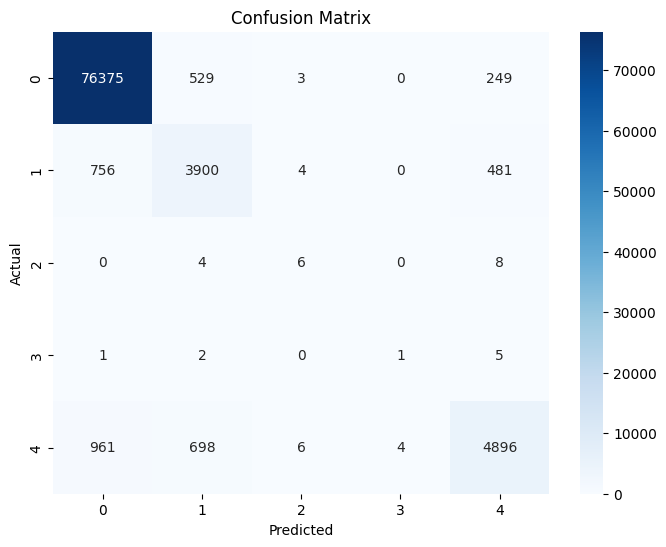

Classification report for voting_clf_16:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.80      0.79      0.80      5141
           2       0.75      0.17      0.27        18
           3       1.00      0.11      0.20         9
           4       0.88      0.79      0.83      6565

    accuracy                           0.97     88889
   macro avg       0.88      0.57      0.62     88889
weighted avg       0.96      0.97      0.96     88889

Confusion matrix for voting_clf_16:


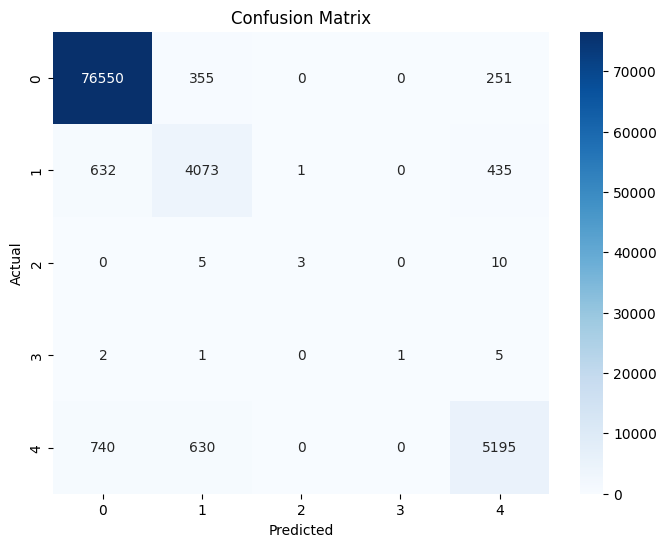

Classification report for voting_clf_17:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     77156
           1       0.73      0.71      0.72      5141
           2       0.24      0.33      0.28        18
           3       0.20      0.11      0.14         9
           4       0.79      0.77      0.78      6565

    accuracy                           0.95     88889
   macro avg       0.59      0.58      0.58     88889
weighted avg       0.95      0.95      0.95     88889

Confusion matrix for voting_clf_17:


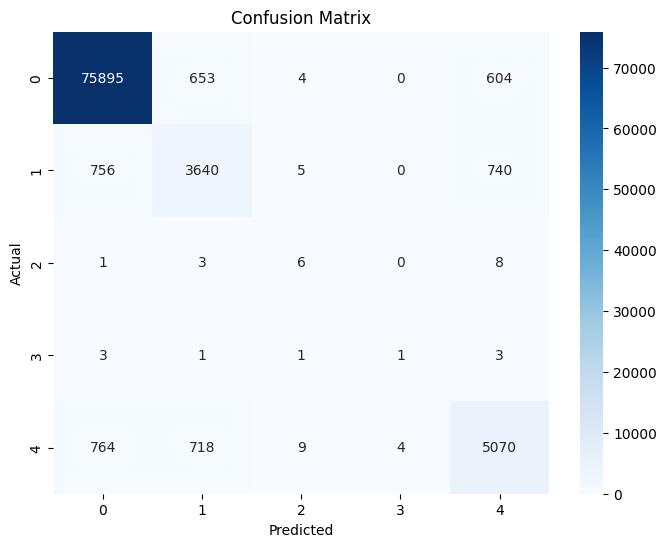

Classification report for voting_clf_18:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     77156
           1       0.76      0.75      0.75      5141
           2       0.30      0.33      0.32        18
           3       0.00      0.00      0.00         9
           4       0.87      0.74      0.80      6565

    accuracy                           0.96     88889
   macro avg       0.58      0.56      0.57     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for voting_clf_18:


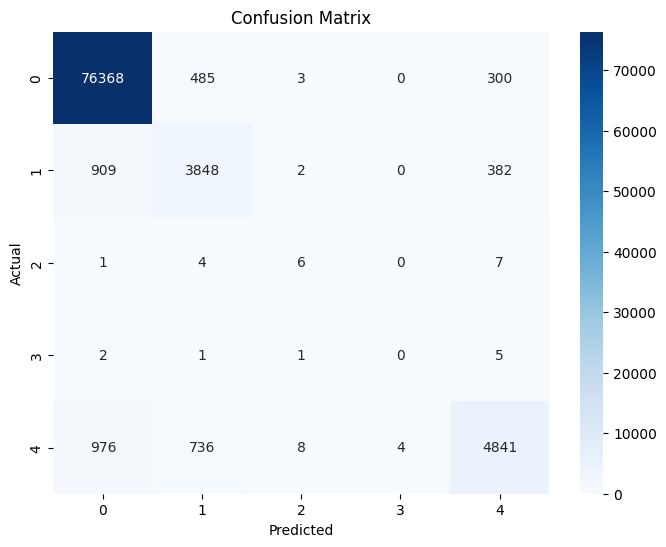

In [99]:
imputer = SimpleImputer(strategy='median')
X = df.drop(columns=['ACMG_class'])
X = imputer.fit_transform(X)
y = df['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

base_estimator1 = DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=seeds[1])
base_estimator2 = LogisticRegression(class_weight=dict(enumerate(class_weights)), max_iter=1000, random_state=42)
base_estimator3 = GaussianNB()

forrestClassifier = RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=42)
treeClassifier = DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=42)
baggingClassifier = BaggingClassifier(random_state=42)
adaBoostTree = AdaBoostClassifier(estimator=base_estimator1, random_state=42)
adaBoostLogistc = AdaBoostClassifier(estimator=base_estimator2, random_state=42)
adaBoostGN = AdaBoostClassifier(estimator=base_estimator3, random_state=42)
logistic = LogisticRegression(max_iter=1000, class_weight=dict(enumerate(class_weights)), random_state=42)

voting_clf_1 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ac', adaBoostTree)],
        voting='soft'
    )
voting_clf_2 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ac', adaBoostTree), ('bc', baggingClassifier)],
        voting='soft'
    )
voting_clf_3 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ac', adaBoostTree), ('lc', logistic)],
        voting='soft'
    )
voting_clf_4 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ac', adaBoostTree), ('tc', treeClassifier)],
        voting='soft'
    )
voting_clf_5 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ac', adaBoostTree), ('bc', baggingClassifier)],
        voting='soft'
    )
voting_clf_6 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('al', adaBoostLogistc), ('tc', treeClassifier)],
        voting='soft'
    )
voting_clf_7 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('al', adaBoostLogistc), ('bc', baggingClassifier)],
        voting='soft'
    )
voting_clf_8 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ag', adaBoostGN), ('tc', treeClassifier)],
        voting='soft'
    )
voting_clf_9 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ag', adaBoostGN), ('bc', baggingClassifier)],
        voting='soft'
    )
voting_clf_10 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ag', adaBoostGN), ('al', adaBoostLogistc), ('ac', adaBoostTree), ('bc', baggingClassifier),
                    ('lc', logistic), ('tc', treeClassifier)],
        voting='soft'
    )
voting_clf_11 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('tc', treeClassifier), ('bc', baggingClassifier)],
        voting='soft'
    )
voting_clf_12 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ac', adaBoostTree)],
        voting='hard'
    )
voting_clf_13 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ag', adaBoostGN), ('tc', treeClassifier)],
        voting='hard'
    )
voting_clf_14 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ag', adaBoostGN), ('bc', baggingClassifier)],
        voting='hard'
    )
voting_clf_15 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('ag', adaBoostGN), ('al', adaBoostLogistc), ('ac', adaBoostTree), ('bc', baggingClassifier),
                    ('lc', logistic), ('tc', treeClassifier)],
        voting='hard'
    )
voting_clf_16 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('tc', treeClassifier), ('bc', baggingClassifier)],
        voting='hard'
    )
voting_clf_17 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('tc', treeClassifier), ('lc', logistic)],
        voting='soft'
    )
voting_clf_18 = VotingClassifier(
        estimators=[('fc', forrestClassifier), ('tc', treeClassifier), ('lc', logistic)],
        voting='hard'
    )
models = [
    ("voting_clf_1", voting_clf_1),
    ("voting_clf_2", voting_clf_2),
    ("voting_clf_3", voting_clf_3),
    ("voting_clf_4", voting_clf_4),
    ("voting_clf_5", voting_clf_5),
    ("voting_clf_6", voting_clf_6),
    ("voting_clf_7", voting_clf_7),
    ("voting_clf_8", voting_clf_8),
    ("voting_clf_9", voting_clf_9),
    ("voting_clf_10", voting_clf_10),
    ("voting_clf_11", voting_clf_11),
    ("voting_clf_12", voting_clf_12),
    ("voting_clf_13", voting_clf_13),
    ("voting_clf_14", voting_clf_14),
    ("voting_clf_15", voting_clf_15),
    ("voting_clf_16", voting_clf_16),
    ("voting_clf_17", voting_clf_17),
    ("voting_clf_18", voting_clf_18)

]

for model_name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    report = classification_report(y_test, y_pred)
    print(f"Classification report for {model_name}:")
    print(report)

    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion matrix for {model_name}:")
    plt.figure(figsize=(8, 6))
    class_names = [0,1,2,3,4]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


### Data Split Experiment

Since performance ends up being the lowest for minority class, then it might be beneficial to train 2 models. One will recorgnise the difference between the majority classes and minority classes. Then a model will be specifically fitted to recongise between the minority classes seperately.

So first the model decides between majority class and agregated minority classes and then if the minority class was chosen, a seperate model decides which minority class it is. I do not yet know how to fully implement that as one model so instead it is implemenetd as two seperate models to see if the approach is viable.

<b> Important: </b>
* Use Leave-One-Out Cross-Validation in the future for minority classes

In [100]:
mapping_1 = {0: 0, 1: 1, 2: 1, 3: 1, 4: 2}
new_df_1 = df.copy()
new_df_1['ACMG_class'] = new_df_1['ACMG_class'].replace(mapping_1)
mapping_filter1 = {1:0, 2:1, 3:2}
filtered_df_1 = df[(df['ACMG_class'] == 1) | (df['ACMG_class'] == 2) | (df['ACMG_class'] == 3)]
filtered_df_1["ACMG_class"] = filtered_df_1["ACMG_class"].replace(mapping_filter1)

mapping_2 = {0: 0, 1: 1, 2: 2, 3: 2, 4: 3}
mapping_filter2 = {2:0, 3:1}
new_df_2 = df.copy()
new_df_2['ACMG_class'] = new_df_2['ACMG_class'].replace(mapping_2)
filtered_df_2 = df[(df['ACMG_class'] == 2) | (df['ACMG_class'] == 3)]
filtered_df_2["ACMG_class"] = filtered_df_2["ACMG_class"].replace(mapping_filter2)

<b> Approach I: </b>

Class Assignment:
* 'Benign': 0
* 'Likely%40Benign': 1
* 'Likely%40Pathogenic': 1
* 'Pathogenic': 1
* 'Uncertain%40Significance': 2

For New_DF_1
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.79      0.79      0.79      5168
           2       0.88      0.78      0.83      6565

    accuracy                           0.96     88889
   macro avg       0.89      0.85      0.87     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for Random Forest:


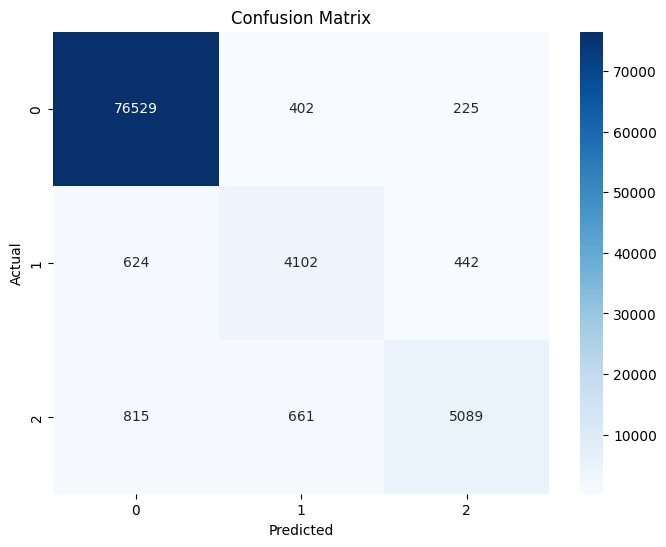

Classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     77156
           1       0.48      0.77      0.59      5168
           2       0.61      0.77      0.68      6565

    accuracy                           0.91     88889
   macro avg       0.69      0.82      0.74     88889
weighted avg       0.93      0.91      0.92     88889

Confusion matrix for AdaBoost:


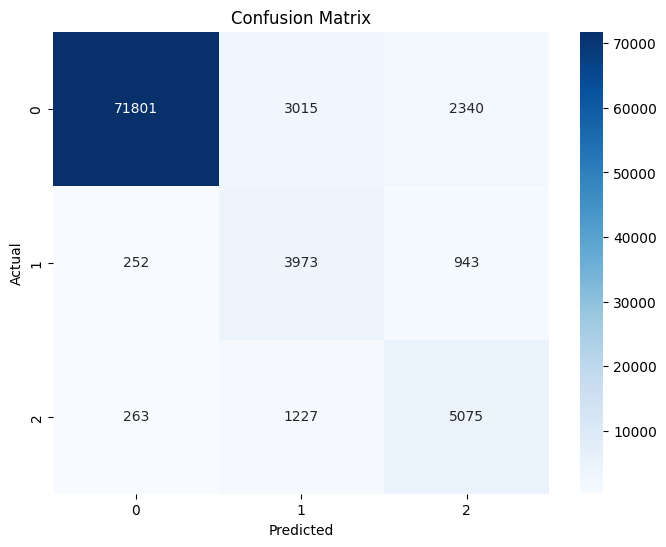

Classification report for Bagging:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.79      0.80      0.80      5168
           2       0.87      0.79      0.82      6565

    accuracy                           0.97     88889
   macro avg       0.88      0.86      0.87     88889
weighted avg       0.96      0.97      0.96     88889

Confusion matrix for Bagging:


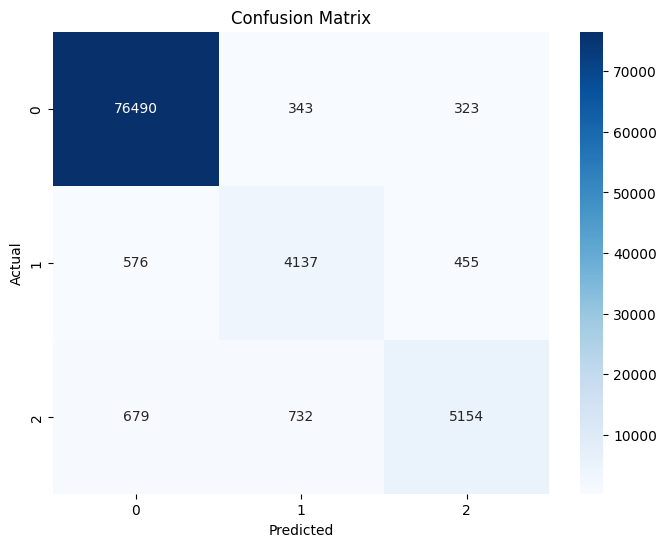

Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     77156
           1       0.72      0.71      0.72      5168
           2       0.77      0.78      0.78      6565

    accuracy                           0.95     88889
   macro avg       0.83      0.82      0.82     88889
weighted avg       0.95      0.95      0.95     88889

Confusion matrix for Decision Tree:


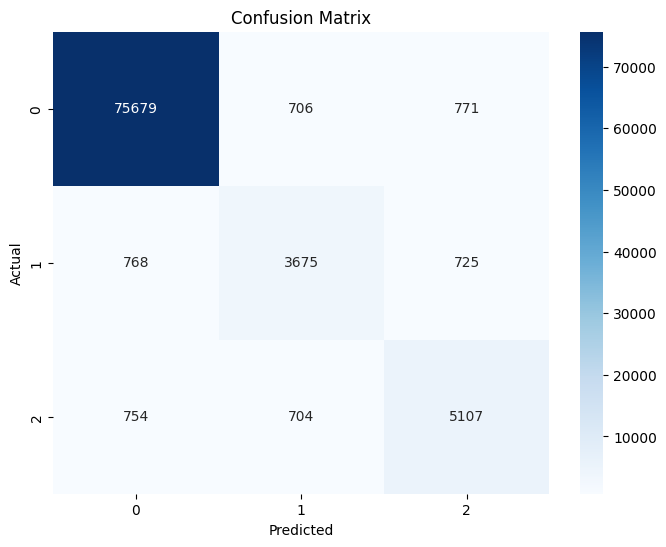

Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     77156
           1       0.17      0.45      0.25      5168
           2       0.43      0.56      0.49      6565

    accuracy                           0.79     88889
   macro avg       0.52      0.61      0.54     88889
weighted avg       0.88      0.79      0.82     88889

Confusion matrix for Logistic Regression:


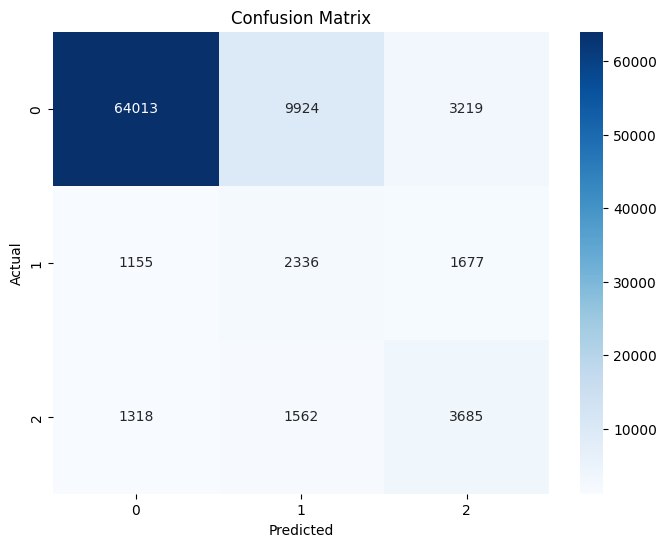

In [101]:
imputer = SimpleImputer(strategy='median')
X = new_df_1.drop(columns=['ACMG_class'])
X = imputer.fit_transform(X)
y = new_df_1['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
seeds = [42, 123, 456, 789, 555, 111, 888, 999]

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

models = [
    ('Random Forest', RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=seeds[0])),
    ('AdaBoost', AdaBoostClassifier(random_state=seeds[1])),
    ('Bagging', BaggingClassifier(random_state=seeds[2])),
    ('Decision Tree', DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=seeds[3])),
    ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight=dict(enumerate(class_weights)), random_state=seeds[4])),
    
]

print("For New_DF_1")

for model_name, model in models:
    clf = model

    pipeline = Pipeline([
        ('classifier', clf)
    ])

    if model_name == 'Voting Classifier':
        clf.set_params(gb__sample_weight=class_weights[np.searchsorted(np.unique(y_train), y_train)])
    elif model_name == 'AdaBoost':
        sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
        pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    else:
        pipeline.fit(X_train, y_train)
    
    if model_name != 'AdaBoost':
        y_pred = pipeline.predict(X_test)
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        y_pred = pipeline.predict(X_test)
        
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        classes = np.unique(y)
        cm = confusion_matrix(y_test, y_pred, labels=classes)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()


For Filtered_DF_1
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5134
           1       1.00      0.06      0.12        31
           2       0.00      0.00      0.00        21

    accuracy                           0.99      5186
   macro avg       0.66      0.35      0.37      5186
weighted avg       0.99      0.99      0.99      5186

Confusion matrix for Random Forest:


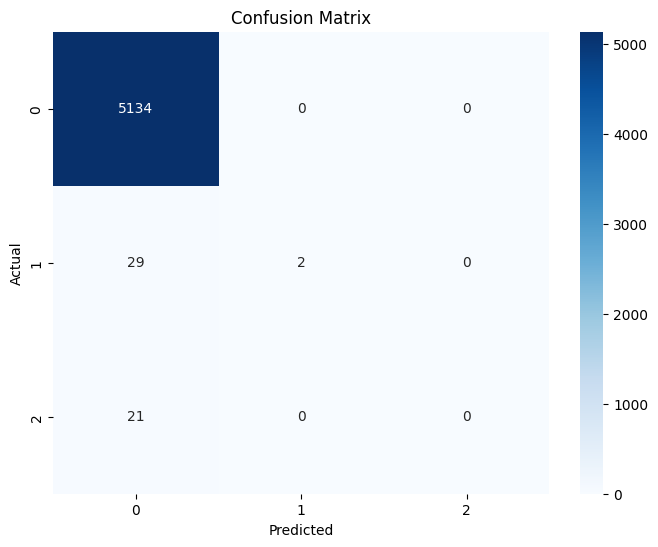

Classification report for AdaBoost:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      5134
           1       0.04      0.90      0.07        31
           2       0.62      0.38      0.47        21

    accuracy                           0.87      5186
   macro avg       0.55      0.72      0.49      5186
weighted avg       0.99      0.87      0.92      5186

Confusion matrix for AdaBoost:


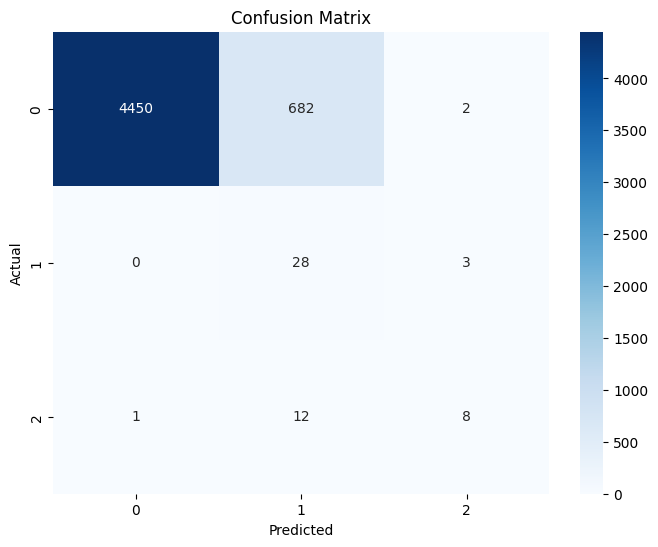

Classification report for Bagging:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5134
           1       0.62      0.48      0.55        31
           2       1.00      0.29      0.44        21

    accuracy                           0.99      5186
   macro avg       0.87      0.59      0.66      5186
weighted avg       0.99      0.99      0.99      5186

Confusion matrix for Bagging:


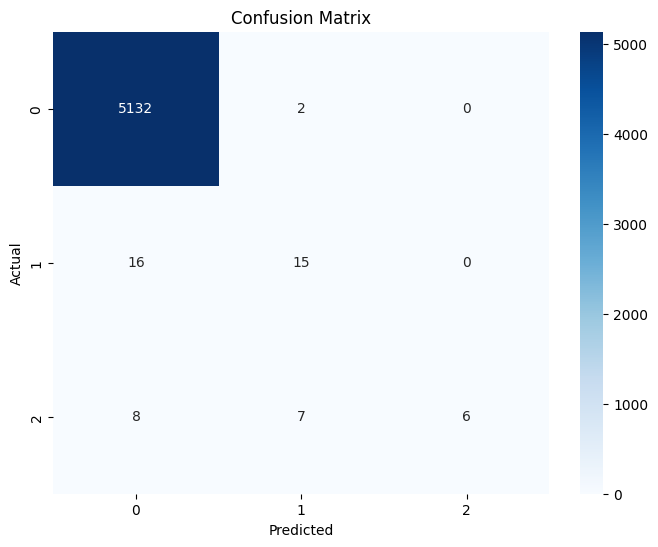

Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5134
           1       0.40      0.45      0.42        31
           2       0.71      0.24      0.36        21

    accuracy                           0.99      5186
   macro avg       0.70      0.56      0.59      5186
weighted avg       0.99      0.99      0.99      5186

Confusion matrix for Decision Tree:


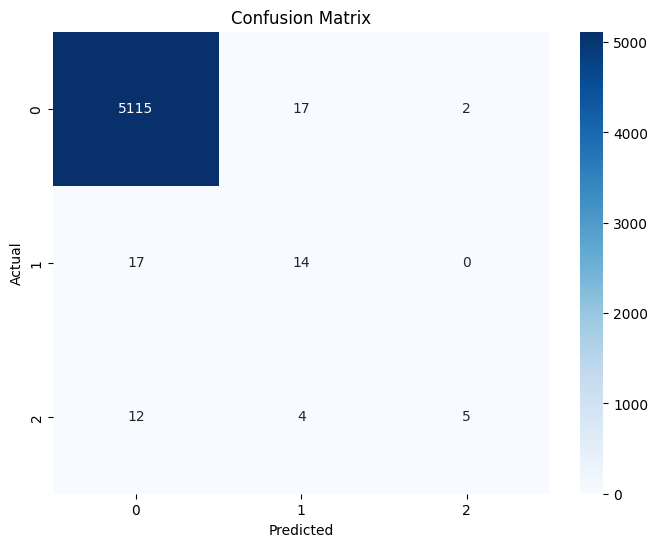

Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      5134
           1       0.01      0.39      0.02        31
           2       0.02      0.33      0.03        21

    accuracy                           0.70      5186
   macro avg       0.34      0.48      0.29      5186
weighted avg       0.99      0.70      0.82      5186

Confusion matrix for Logistic Regression:


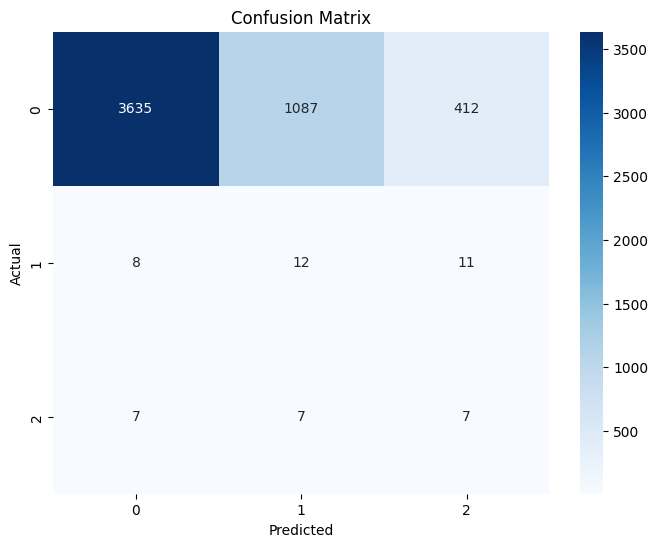

In [102]:
imputer = SimpleImputer(strategy='median')
X = filtered_df_1.drop(columns=['ACMG_class'])
X = imputer.fit_transform(X)
y = filtered_df_1['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
seeds = [42, 123, 456, 789, 555, 111, 888, 999]

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

models = [
    ('Random Forest', RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=seeds[0])),
    ('AdaBoost', AdaBoostClassifier(random_state=seeds[1])),
    ('Bagging', BaggingClassifier(random_state=seeds[2])),
    ('Decision Tree', DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=seeds[3])),
    ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight=dict(enumerate(class_weights)), random_state=seeds[4])),
    
]

print("For Filtered_DF_1")

for model_name, model in models:
    clf = model

    pipeline = Pipeline([
        ('classifier', clf)
    ])

    if model_name == 'Voting Classifier':
        clf.set_params(gb__sample_weight=class_weights[np.searchsorted(np.unique(y_train), y_train)])
    elif model_name == 'AdaBoost':
        sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
        pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    else:
        pipeline.fit(X_train, y_train)
    
    if model_name != 'AdaBoost':
        y_pred = pipeline.predict(X_test)
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        y_pred = pipeline.predict(X_test)
        
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        classes = np.unique(y)
        cm = confusion_matrix(y_test, y_pred, labels=classes)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()


<b> Approach II: </b>

Class Assignment:
* 'Benign': 0
* 'Likely%40Benign': 1
* 'Likely%40Pathogenic': 2
* 'Pathogenic': 2
* 'Uncertain%40Significance': 3

For New_DF_2
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.79      0.79      0.79      5141
           2       1.00      0.07      0.14        27
           3       0.88      0.78      0.82      6565

    accuracy                           0.96     88889
   macro avg       0.91      0.66      0.69     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for Random Forest:


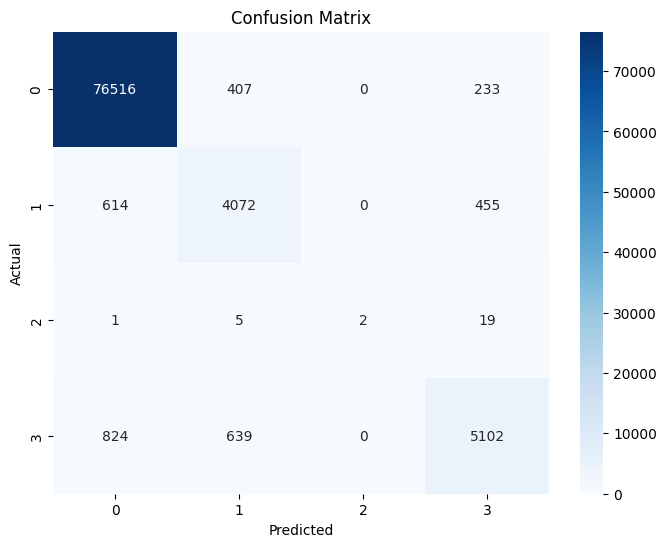

Classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     77156
           1       0.34      0.40      0.37      5141
           2       0.03      0.67      0.06        27
           3       0.52      0.63      0.57      6565

    accuracy                           0.89     88889
   macro avg       0.47      0.66      0.49     88889
weighted avg       0.91      0.89      0.90     88889

Confusion matrix for AdaBoost:


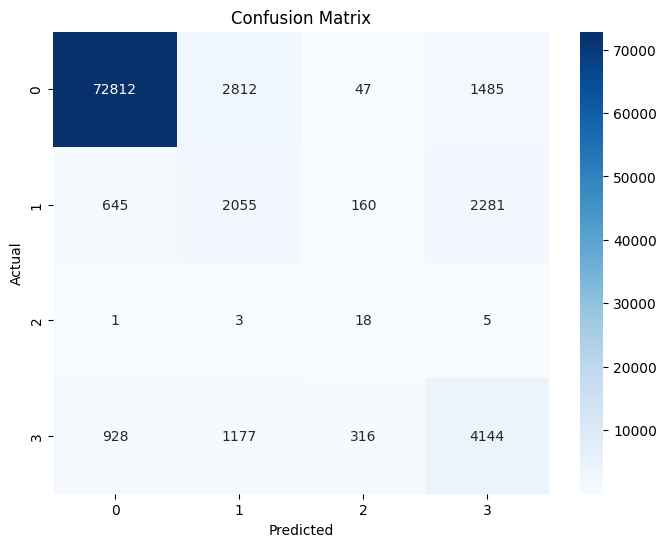

Classification report for Bagging:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.79      0.79      0.79      5141
           2       0.64      0.26      0.37        27
           3       0.87      0.79      0.83      6565

    accuracy                           0.96     88889
   macro avg       0.82      0.71      0.74     88889
weighted avg       0.96      0.96      0.96     88889

Confusion matrix for Bagging:


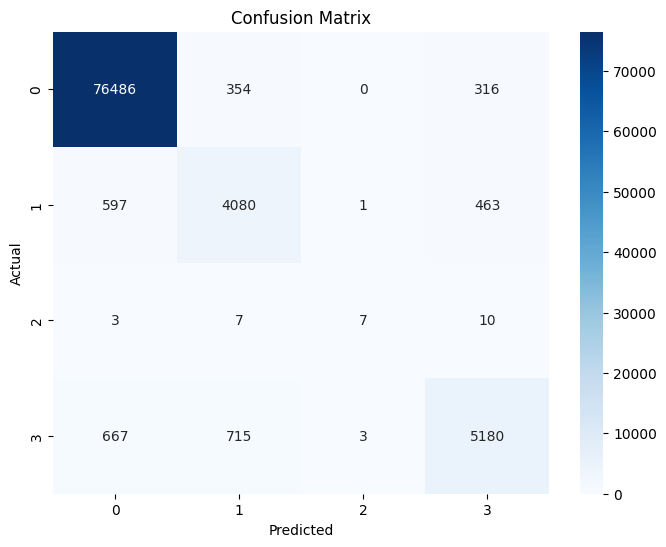

Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     77156
           1       0.71      0.70      0.70      5141
           2       0.25      0.33      0.29        27
           3       0.77      0.77      0.77      6565

    accuracy                           0.95     88889
   macro avg       0.68      0.70      0.68     88889
weighted avg       0.95      0.95      0.95     88889

Confusion matrix for Decision Tree:


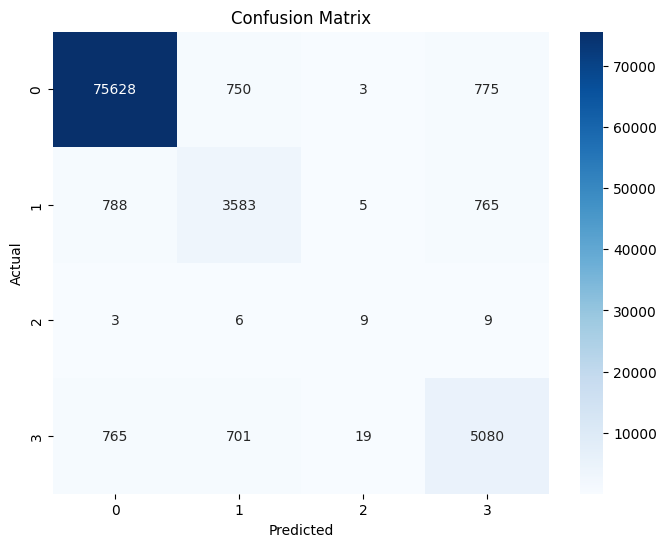

Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88     77156
           1       0.14      0.32      0.20      5141
           2       0.00      0.74      0.01        27
           3       0.39      0.46      0.42      6565

    accuracy                           0.75     88889
   macro avg       0.38      0.58      0.38     88889
weighted avg       0.87      0.75      0.80     88889

Confusion matrix for Logistic Regression:


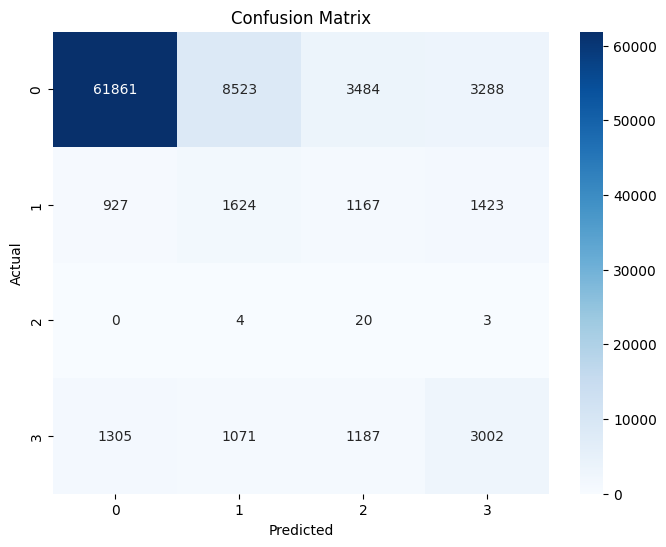

In [103]:
imputer = SimpleImputer(strategy='median')
X = new_df_2.drop(columns=['ACMG_class'])
X = imputer.fit_transform(X)
y = new_df_2['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
seeds = [42, 123, 456, 789, 555, 111, 888, 999]

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

models = [
    ('Random Forest', RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=seeds[0])),
    ('AdaBoost', AdaBoostClassifier(random_state=seeds[1])),
    ('Bagging', BaggingClassifier(random_state=seeds[2])),
    ('Decision Tree', DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=seeds[3])),
    ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight=dict(enumerate(class_weights)), random_state=seeds[4])),
    
]

print("For New_DF_2")

for model_name, model in models:
    clf = model

    pipeline = Pipeline([
        ('classifier', clf)
    ])

    if model_name == 'Voting Classifier':
        clf.set_params(gb__sample_weight=class_weights[np.searchsorted(np.unique(y_train), y_train)])
    elif model_name == 'AdaBoost':
        sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
        pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    else:
        pipeline.fit(X_train, y_train)
    
    if model_name != 'AdaBoost':
        y_pred = pipeline.predict(X_test)
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        y_pred = pipeline.predict(X_test)
        
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        classes = np.unique(y)
        cm = confusion_matrix(y_test, y_pred, labels=classes)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()


Weighted

For Filtered_DF_2
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.70      0.91      0.79        23
           1       0.60      0.25      0.35        12

    accuracy                           0.69        35
   macro avg       0.65      0.58      0.57        35
weighted avg       0.67      0.69      0.64        35

Confusion matrix for Random Forest:


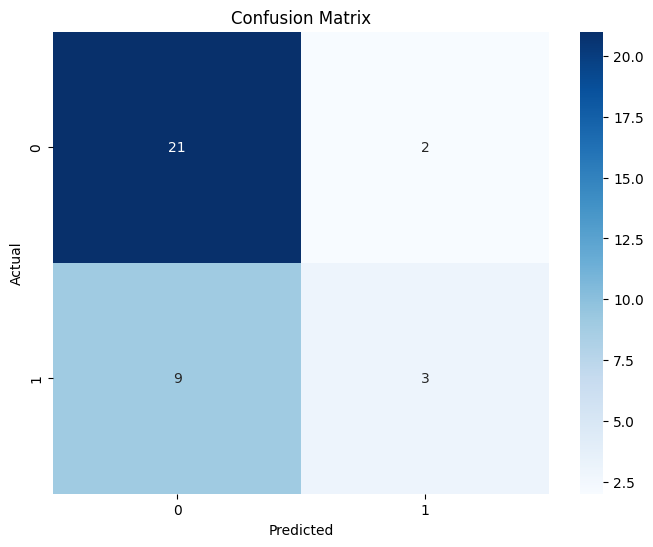

Classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        23
           1       0.53      0.67      0.59        12

    accuracy                           0.69        35
   macro avg       0.67      0.68      0.67        35
weighted avg       0.71      0.69      0.69        35

Confusion matrix for AdaBoost:


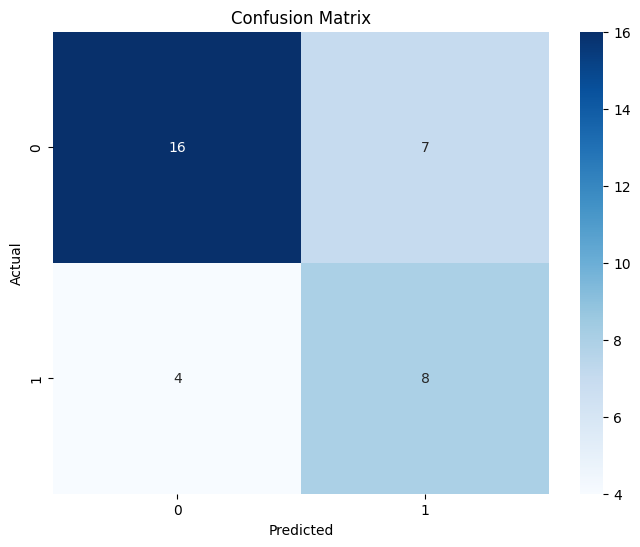

Classification report for Bagging:
              precision    recall  f1-score   support

           0       0.67      0.87      0.75        23
           1       0.40      0.17      0.24        12

    accuracy                           0.63        35
   macro avg       0.53      0.52      0.50        35
weighted avg       0.58      0.63      0.58        35

Confusion matrix for Bagging:


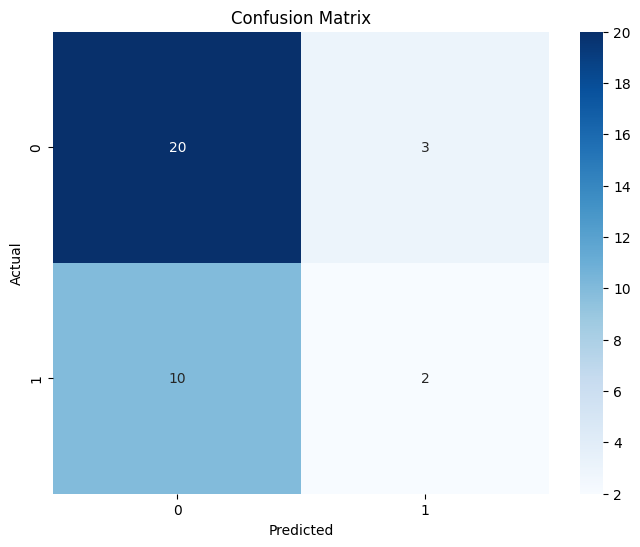

Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75        23
           1       0.50      0.42      0.45        12

    accuracy                           0.66        35
   macro avg       0.61      0.60      0.60        35
weighted avg       0.64      0.66      0.65        35

Confusion matrix for Decision Tree:


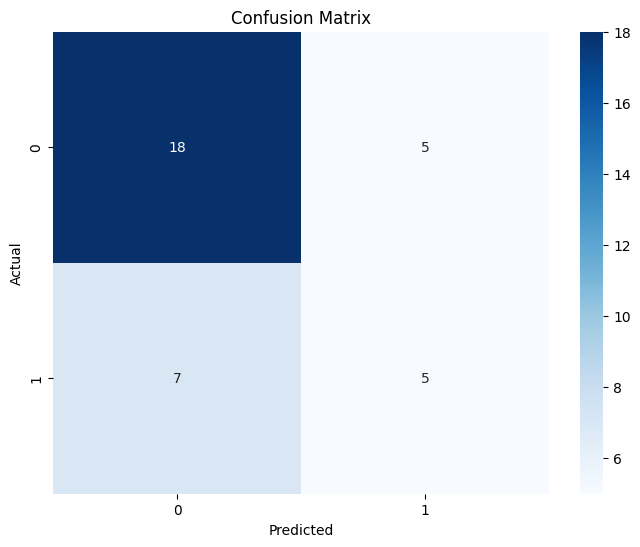

Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.73      0.48      0.58        23
           1       0.40      0.67      0.50        12

    accuracy                           0.54        35
   macro avg       0.57      0.57      0.54        35
weighted avg       0.62      0.54      0.55        35

Confusion matrix for Logistic Regression:


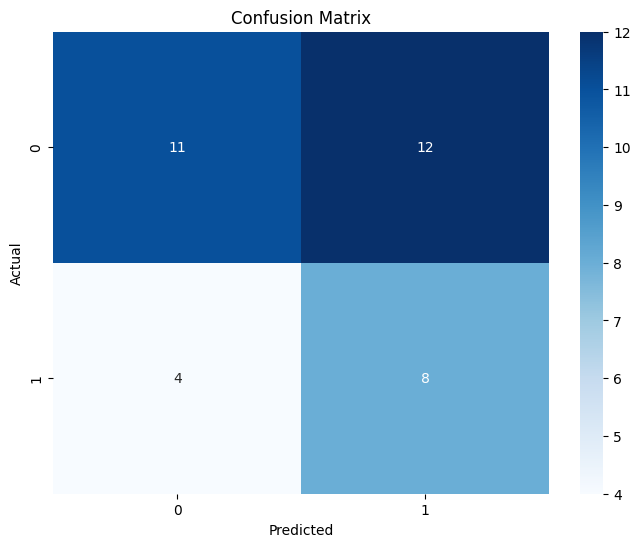

In [104]:
imputer = SimpleImputer(strategy='median')
X = filtered_df_2.drop(columns=['ACMG_class'])
X = imputer.fit_transform(X)
y = filtered_df_2['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
seeds = [42, 123, 456, 789, 555, 111, 888, 999]

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

models = [
    ('Random Forest', RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=seeds[0])),
    ('AdaBoost', AdaBoostClassifier(random_state=seeds[1])),
    ('Bagging', BaggingClassifier(random_state=seeds[2])),
    ('Decision Tree', DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=seeds[3])),
    ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight=dict(enumerate(class_weights)), random_state=seeds[4])),
    
]

print("For Filtered_DF_2")

for model_name, model in models:
    clf = model

    pipeline = Pipeline([
        ('classifier', clf)
    ])

    if model_name == 'Voting Classifier':
        clf.set_params(gb__sample_weight=class_weights[np.searchsorted(np.unique(y_train), y_train)])
    elif model_name == 'AdaBoost':
        sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
        pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    else:
        pipeline.fit(X_train, y_train)
    
    if model_name != 'AdaBoost':
        y_pred = pipeline.predict(X_test)
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        y_pred = pipeline.predict(X_test)
        
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        classes = np.unique(y)
        cm = confusion_matrix(y_test, y_pred, labels=classes)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()


Unwieghted

For Filtered_DF_2


Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80        23
           1       0.62      0.42      0.50        12

    accuracy                           0.71        35
   macro avg       0.68      0.64      0.65        35
weighted avg       0.70      0.71      0.70        35

Confusion matrix for Random Forest:


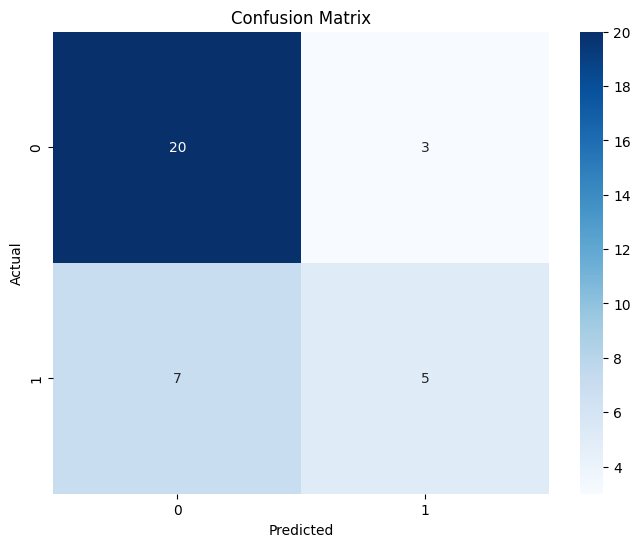

Classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        23
           1       0.53      0.67      0.59        12

    accuracy                           0.69        35
   macro avg       0.67      0.68      0.67        35
weighted avg       0.71      0.69      0.69        35

Confusion matrix for AdaBoost:


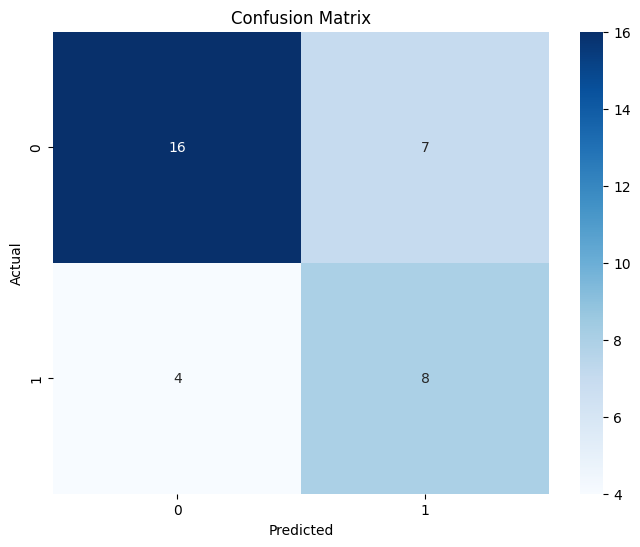

Classification report for Bagging:
              precision    recall  f1-score   support

           0       0.67      0.87      0.75        23
           1       0.40      0.17      0.24        12

    accuracy                           0.63        35
   macro avg       0.53      0.52      0.50        35
weighted avg       0.58      0.63      0.58        35

Confusion matrix for Bagging:


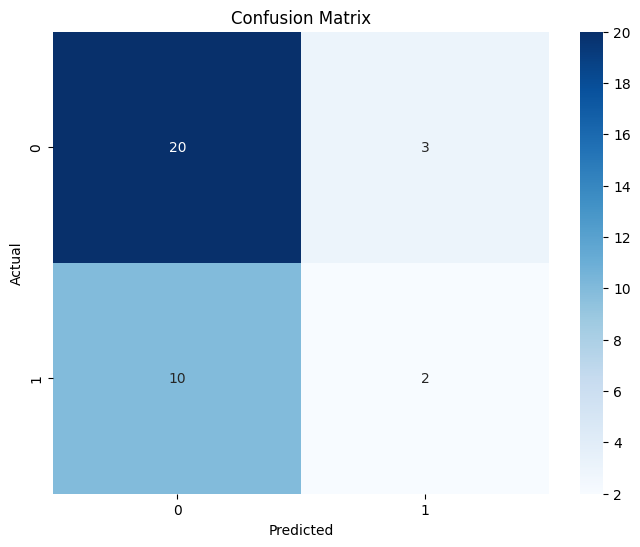

Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        23
           1       0.70      0.58      0.64        12

    accuracy                           0.77        35
   macro avg       0.75      0.73      0.73        35
weighted avg       0.77      0.77      0.77        35

Confusion matrix for Decision Tree:


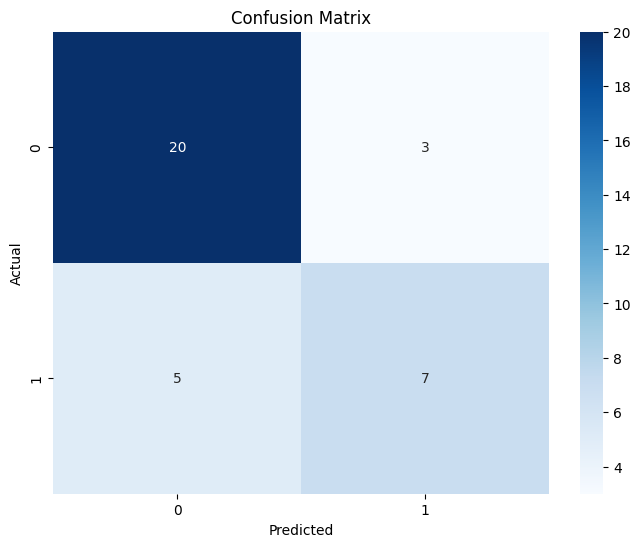

Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.63      0.83      0.72        23
           1       0.20      0.08      0.12        12

    accuracy                           0.57        35
   macro avg       0.42      0.45      0.42        35
weighted avg       0.48      0.57      0.51        35

Confusion matrix for Logistic Regression:


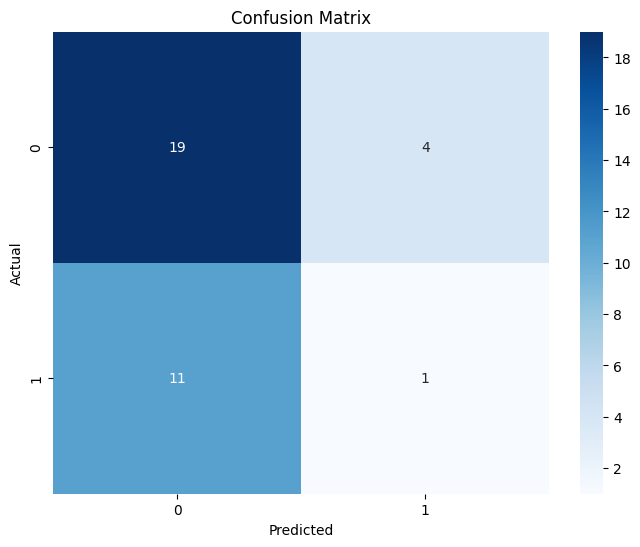

In [105]:
imputer = SimpleImputer(strategy='median')
X = filtered_df_2.drop(columns=['ACMG_class'])
X = imputer.fit_transform(X)
y = filtered_df_2['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
seeds = [42, 123, 456, 789, 555, 111, 888, 999]

models = [
    ('Random Forest', RandomForestClassifier( random_state=seeds[0])),
    ('AdaBoost', AdaBoostClassifier(random_state=seeds[1])),
    ('Bagging', BaggingClassifier(random_state=seeds[2])),
    ('Decision Tree', DecisionTreeClassifier(random_state=seeds[3])),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=seeds[4])),
    
]

print("For Filtered_DF_2")

for model_name, model in models:
    clf = model

    pipeline = Pipeline([
        ('classifier', clf)
    ])

    if model_name == 'Voting Classifier':
        clf.set_params(gb__sample_weight=class_weights[np.searchsorted(np.unique(y_train), y_train)])
    elif model_name == 'AdaBoost':
        #sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
        pipeline.fit(X_train, y_train)
    else:
        pipeline.fit(X_train, y_train)
    
    if model_name != 'AdaBoost':
        y_pred = pipeline.predict(X_test)
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        y_pred = pipeline.predict(X_test)
        
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        classes = np.unique(y)
        cm = confusion_matrix(y_test, y_pred, labels=classes)
        print(f"Confusion matrix for {model_name}:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()


### Explainability

Temporairly made for the Random Forrest Classifier model, can be later done for any model

In [106]:
import warnings
warnings.filterwarnings('ignore')

In [107]:
imputer = SimpleImputer(strategy='median')
X = df.drop(columns=['ACMG_class'])
feature_names = X.columns
X = imputer.fit_transform(X)
y = df['ACMG_class']
X = pd.DataFrame(X, columns=feature_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y_train)
model = RandomForestClassifier(class_weight=dict(enumerate(class_weights)))
model.fit(X_train, y_train)

class_probs = model.predict_proba(X)
exp = dx.Explainer(model, X_test, y_test)
fi = exp.model_parts()
fi.plot()

Preparation of a new explainer is initiated

  -> data              : 88889 rows 108 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 88889 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000027143578040> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.0563, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.85, mean = 0.298, max = 4.0
  -> model_info        : package sklearn

A new explainer has been created!


In [108]:
exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 108/108 [00:31<00:00,  3.46it/s]


<b> SHAP may need to be abandoned due to how long it takes to produce the results </b>

In [113]:
imputer = SimpleImputer(strategy='median')
X = df.drop(columns=['ACMG_class'])
feature_names = X.columns
X = imputer.fit_transform(X)
y = df['ACMG_class']
X = pd.DataFrame(X, columns=feature_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y_train)
model = RandomForestClassifier(class_weight=dict(enumerate(class_weights)))
model.fit(X_train, y_train)

class_probs = model.predict_proba(X)
exp = dx.Explainer(model, X_test, y_test)
exp.predict_parts(X_test.iloc[6], type='shap').plot()

Preparation of a new explainer is initiated

  -> data              : 88889 rows 108 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 88889 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000027143578040> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.0564, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.89, mean = 0.298, max = 4.0
  -> model_info        : package sklearn

A new explainer has been created!
